In [1]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import re
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
from bs4 import BeautifulSoup
import re
from uuid import uuid4

In [3]:
class Crawler:

    def get_html(self):
        pass

    def get_card_info(self):
        pass

    def get_links(self, page):
        pass

In [4]:
class CrawlerEda(Crawler):

    def get_html(self, page):
        chrome_options = Options()
        chrome_options.add_argument("--disable-extensions")
        chrome_options.add_argument("--disable-popup-blocking")

        browser = webdriver.Chrome(options=chrome_options)
        url = f"https://eda.ru/recepty?page={page}"
        #browser.implicitly_wait(30)
        browser.get(url)
        wait = WebDriverWait(browser, 10)
        soup = BeautifulSoup(browser.page_source, 'html.parser')
        return soup

    def get_card_info(self, link):
        chrome_options = Options()
        chrome_options.add_argument("--disable-extensions")
        chrome_options.add_argument("--disable-popup-blocking")

        browser = webdriver.Chrome(options=chrome_options)
        action = ActionChains(browser)
        count = 0

        #linker = linkers[number]['link']
        #browser.get(linker)
        browser.get(link)

        wait = WebDriverWait(browser, 10)
        browser.implicitly_wait(30)

        soup_card = BeautifulSoup(browser.page_source, 'html.parser')
        return soup_card

    def get_soup(self, url):
        return BeautifulSoup(requests.get(url).text, "html.parser")

    def get_links(self,first_page, last_page):
        links = []
        for i in range(first_page, last_page):
            html = CrawlerEda().get_html(i)
            links.extend(ParserEda(html).get_cards())
            #print(links)
        return links

In [5]:
class Parser:

    def __init__(self, html):
        self.html = html

    def get_cards(self):
        pass

    def __get_ingredients(self):
        pass

    def __get_calories(self):
        pass

    def __get_manual(self):
        pass

    def __get_category(self):
        pass

    def get_recipe(self):
        pass

In [69]:
class ParserEda(Parser):

    def get_cards(self):
        linkers = []
        for recipe in self.html.findAll('div', class_='emotion-1f6ych6'):
            try:
                link = "https://eda.ru"+recipe.find('a', class_='emotion-12sjte8').get('href')
                photo = str(recipe.find('img', class_='emotion-1bi124x').get('src')).replace('c180x180', 'c500x500')
                #print(link)
                #print(photo)
                linkers.append(Link(link, photo))
            except AttributeError:
                print("There's no item with that code")
        #print(len(linkers))
        return linkers

    def get_recipe(self, id_):
        #print("get_recipe")

        parser = ParserEda(self.html)
        card = self.html.find('div', class_='emotion-2k9cfu')

        name_dish = card.find('div', class_='emotion-19rdt1j').find('h1', class_='emotion-gl52ge').text
        print(name_dish)

        count_portion = str(re.sub(r'\bпорц[ий|ия|ии]*\b', '', card.find('div', class_='emotion-1047m5l').text).strip())
        cook_time = card.find('div', class_='emotion-18q6z5o').find('div', class_='emotion-my9yfq').text
        #print(cook_time)

        manual = parser.__get_manual().replace('\'', '\'\'')

        recipe = Recipe(name_dish, count_portion, cook_time, manual)

        #time.sleep(2)

        helper = DBHelper()
        #table_name, primary_keys, foreign_keys, references, unique_args, other_args, auto
        helper.generic_create_table('recipe',
                            [('id', 'INTEGER')],
                            None,
                            None,
                            ['name_dish'],
                            ['count_portion', 'cook_time', 'manual'],
                            True)

        helper.insert('recipe', ['id', 'name_dish', 'count_portion', 'cook_time', 'manual'],
                                [id_, recipe.name, recipe.count_portion, recipe.cook_time, recipe.manual ])

        #self, table_name, column_args, arg
        #находим айдишник нужного рецепта
        #recipe_ = helper.get('recipe', ['name_dish', 'count_portion'], [name_dish, count_portion])
        #id_ = recipe_[0][0]

        categories = parser.__get_categories(id_)

        ingredients = parser.__get_ingredients(id_)

        calories = parser.__get_calories(id_)

        #name_dish, count_portion, cook_time, ingredients, categories, manual

    #autoincrement
    def __get_ingredients(self, id):
        all_ingredients = {}
        name_ingredients = []

        for ing in self.html.findAll('div', class_='emotion-bjn8wh'):
            name_ingredients.append(ing.text)

        for i in range (len(name_ingredients)):
            all_ingredients[name_ingredients[i]] = self.html.findAll('span', class_='emotion-bsdd3p')[i].text
            #print(all_ingredients[name_ingredients[i]], name_ingredients[i])

        helper = DBHelper()
        helper.generic_create_table('ingredient',
                            [('id', 'INTEGER')],
                            None,
                            None,
                            ['name_ingr'],
                            None,
                            True)

        #table_name, primary_keys, foreign_keys, references, unique_args, other_args, auto
        helper.generic_create_table('recipe_ingredients',
                            [('id', 'INTEGER')],
                            ['recipe_id', 'ingr_id'],
                            [('recipe', 'id'), ('ingredient', 'id')],
                            None,
                            ['count'],
                            True)

        helper.get_unique('recipe_ingredients', 'unique_index_recipe_ingr', ['recipe_id', 'ingr_id'])

        for name in name_ingredients:
            helper.insert('ingredient', ['name_ingr'], [str(name).replace("'", "''")])

        for i in range (len(name_ingredients)):
            #self, table_name, column_args, args
            ingr_ = helper.get('ingredient', ['name_ingr'], [str(name_ingredients[i]).replace("'", "''")])
            helper.insert('recipe_ingredients',
                          ['recipe_id', 'ingr_id', 'count'],
                          [id, ingr_[0][0],
                           all_ingredients[ingr_[0][1]]])

        return all_ingredients

    #autoincrement
    def __get_categories(self, id):
        categories = []

        #дурацкие категории
        bad_categories = ['Главная', 'Проверено «Едой»', 'Пошаговые рецепты', 'Видеорецепты', 'Рецепты с историей']

        for category in self.html.find('div', class_='emotion-fq1t0q').findAll('span', class_='emotion-1h6i17m'):
            if category.text not in bad_categories:
                categories.append(category.text)

        #связка с бд, возможно уберу
        helper = DBHelper()
        helper.generic_create_table('category',
                                    [('id', 'INTEGER')],
                                    None,
                                    None,
                                    ['name_cat'],
                                    None,
                                    True)
        #table_name, primary_keys, foreign_keys, references, unique_args, other_args, auto
        helper.generic_create_table('recipe_categories',
                                    [('id', 'INTEGER')],
                                    ['recipe_id', 'cat_id'],
                                    [('recipe', 'id'), ('category', 'id')],
                                    None,
                                    None,
                                    True)

        helper.get_unique('recipe_categories', 'unique_index_recipe_cat', ['recipe_id', 'cat_id'])

        for category in categories:
            helper.insert('category', ['name_cat'], [category])
            helper.insert('recipe_categories', ['recipe_id', 'cat_id'],
                          [id, helper.get('category', ['name_cat'],
                                          [category])[0][0]])

        return categories

    #
    def __get_calories(self, id):
        calories = []

        for j in range(4):
            calories.append(self.html.findAll('div', class_='emotion-8fp9e2')[j].text)

        calories_recipe = Calories(calories[0], calories[1], calories[2], calories[3])

        #связка с бд, возможно уберу
        helper = DBHelper()
        #self, table_name, primary_key, foreign_table_name, foreign_col, another_foreign_col, params
        helper.create_table('calories', 'recipe_id', 'recipe', 'recipe_id', 'id', ['calories', 'proteins', 'fats', 'carbohydrates'])
        helper.insert('calories', ['recipe_id', 'calories', 'proteins', 'fats', 'carbohydrates'], [id,
                                                  calories_recipe.calories,
                                                  calories_recipe.proteins,
                                                  calories_recipe.fats,
                                                  calories_recipe.carbohydrates])

        return calories_recipe

    def __get_manual(self):
        manual = ''

        for point in self.html.findAll('span', class_='emotion-1dvddtv'):
            manual += point.text.replace(u'\xa0', u' ') + '\n' + '\n'

        return manual

In [7]:
class Recipe:
    def __init__(self, name_dish, count_portion, cook_time, manual):
        self.name = name_dish
        self.count_portion = count_portion
        self.cook_time = cook_time
        self.manual = manual

In [8]:
class Category:
    def __init__(self, name_cat):
        self.name = name_cat

In [9]:
class Ingredient:
    def __init__(self, name_ingr):
        self.name = name_ingr

In [10]:
class Calories: #можно взять по айдишнику рецепта
    def __init__(self, calories, proteins, fats, carbohydrates):
        self.calories = calories
        self.proteins = proteins
        self.fats = fats
        self.carbohydrates = carbohydrates

In [11]:
class Link:
    def __init__(self, link, photo):
        self.link = link
        self.photo = photo

In [77]:
from sqlite3 import IntegrityError


class DBHelper:

    def __init__(self, db_name = "recipe.db"):
        self.dbname = f"sqlite3:/{db_name}"
        self.conn = sqlite3.connect(db_name)

    #for link, recipe, ingredient and category
    def create_table_simple(self, table_name, params):
        column = ""
        for i in range(len(params) - 1):
            column += params[i] + " TEXT, "
        column += params[len(params) - 1] + " TEXT "

        new_table = f"CREATE TABLE IF NOT EXISTS {table_name} (id INTEGER PRIMARY KEY AUTOINCREMENT , {column})"
        #print(new_table)
        try:
            #print(new_table)
            self.conn.execute(new_table)
            self.conn.commit()
        except sqlite3.Error as err:
            print('Sql error: %s' % (' '.join(err.args)))
            self.conn.rollback()

    #for calories and recipe_ingredients
    def create_table(self, table_name, primary_key, foreign_table_name, foreign_col, another_foreign_col, params, auto = False):
        column = ""
        for i in range(len(params) - 1):
            column += params[i] + " TEXT, "
        column += params[len(params)-1] + " TEXT "

        foreign_key = f"FOREIGN KEY ({foreign_col})  REFERENCES {foreign_table_name} ({another_foreign_col})"

        new_table = f"CREATE TABLE IF NOT EXISTS {table_name} ({primary_key} INTEGER PRIMARY KEY {('', 'AUTOINCREMENT')[auto == True]} , {column}, {foreign_key})"

        try:
            #print(new_table)
            self.conn.execute(new_table)
            self.conn.commit()
        except sqlite3.Error as err:
            print('Sql error: %s' % (' '.join(err.args)))
            self.conn.rollback()

    #id autoincrement
    def generic_create_table(self, table_name, primary_keys, foreign_keys, references, unique_args, other_args, auto):

        new_table = ""

        begin = f"CREATE TABLE IF NOT EXISTS {table_name} ("

        primary = ""
        column = " "

        if len(primary_keys) > 1:
            for i in range(len(primary_keys) - 1):
                primary += primary_keys[i][0] + ", "
                column += primary_keys[i][0] + f" {primary_keys[i][1]}, "

            primary += primary_keys[len(primary_keys) - 1][0]
            column += primary_keys[len(primary_keys) - 1][0] + f" {primary_keys[len(primary_keys) - 1][1]}, "

            new_table += f"PRIMARY KEY ({primary})"
        else:
            begin += f"{primary_keys[0][0]} {primary_keys[0][1]} PRIMARY KEY {('', 'AUTOINCREMENT')[auto]}"
            column += ", " + column

        if foreign_keys is not None and len(foreign_keys) != 0:
            reference = ""
            for i in range(len(references) - 1):
                reference += f"FOREIGN KEY ({foreign_keys[i]}) REFERENCES {references[i][0]}({references[i][1]}), "
                column += foreign_keys[i] + " TEXT, "
            reference += f"FOREIGN KEY ({foreign_keys[len(foreign_keys) - 1]}) REFERENCES" \
                         f" {references[len(references) - 1][0]}({references[len(references) - 1][1]})"
            column += foreign_keys[len(foreign_keys) - 1] + " TEXT, "

            new_table += f", {reference}"

        if unique_args is not None and len(unique_args) != 0:
            unique = ""
            for i in range(len(unique_args) - 1):
                unique += unique_args[i] + ", "
                column += unique_args[i] + " TEXT, "
            unique += unique_args[len(unique_args) - 1]
            column += unique_args[len(unique_args) - 1] + " TEXT, "

            new_table += f", UNIQUE ({unique})"

        if other_args is not None and len(other_args) != 0:
            for i in range(len(other_args) - 1):
                column += other_args[i] + " TEXT, "
            column += other_args[len(other_args)-1] + " TEXT, "

        new_table = begin + (column, column[:-2])[len(primary_keys) == 1] + new_table + ")"

        try:
            #print(new_table)
            self.conn.execute(new_table)
            #print("Выполнилось")
            self.conn.commit()
        except sqlite3.Error as err:
            print('Sql error: %s' % (' '.join(err.args)))
            self.conn.rollback()

    def get_unique(self, table_name, name, unique_columns):
        column = ""
        for i in range(len(unique_columns) - 1):
            column += unique_columns[i] + ", "
        column += unique_columns[len(unique_columns)-1]

        try:
            #print("Unique")
            self.conn.execute(f"CREATE UNIQUE INDEX {name} ON {table_name}({column})")
            #print("Выполнилось")
            self.conn.commit()
        except sqlite3.Error as err:
            print('Sql error: %s' % (' '.join(err.args)))
            self.conn.rollback()

    def insert_check(self, table_name, primary_key, primary_value, args):
        arguments = f"'{primary_value}', '"
        for i in range(len(args) - 1):
            arguments += str(args[i]) + "', '"
        arguments += str(args[len(args) - 1]) + "'"
        #print(arguments)

        new_insert = f"INSERT INTO {table_name} SELECT * FROM (SELECT {arguments}) AS tmp " \
                     f"WHERE NOT EXISTS ( SELECT {primary_key} FROM {table_name} WHERE {primary_key} = '{primary_value}'" \
                     f") LIMIT 1"
        try:
            #print(new_insert)
            self.conn.execute(new_insert)
            #print("Выполнилось")
            self.conn.commit()
        except sqlite3.Error as err:
            print('Sql error: %s' % (' '.join(err.args)))
            self.conn.rollback()

    def insert(self, table_name, column_args, args):
        arguments = "'"
        for i in range(len(args) - 1):
            arguments += str(args[i]) + "', '"
        arguments += str(args[len(args) - 1]) + "'"
        #print(arguments)

        columns = ""
        for i in range(len(column_args) - 1):
            columns += str(column_args[i]) + ", "
        columns += str(column_args[len(column_args) - 1])

        new_insert = f"INSERT INTO {table_name} ({columns}) VALUES ({arguments})"
        #print(new_insert)

        try:
            #print(new_insert)
            self.conn.execute(new_insert)
            #print("Выполнилось")
            self.conn.commit()
        except sqlite3.Error as err:
            print('Sql error: %s' % (' '.join(err.args)))
            self.conn.rollback()

    def print_info(self, table_name):
        new_get = f"SELECT * FROM {table_name}"
        cursor = self.conn.execute(new_get)

        #print("Выполнилось")

        return [row for row in cursor]

    def get(self, table_name, column_args, args):
        query = ""
        for i in range(len(column_args) - 1):
            query += column_args[i] + " = '" + args[i] + "' AND "
        query += column_args[len(column_args) - 1] + " = '" + args[len(column_args) - 1] + "'"

        new_get = f"SELECT * FROM {table_name} WHERE {query}"
        #print(new_get)

        cursor = self.conn.execute(new_get)

        return [row for row in cursor]

    def rollback(self):
        self.conn.rollback()

    #def update(self, flat_id, updates):


    #def delete(self, flat_id):


In [13]:
linkers = CrawlerEda().get_links(1, 5)
print(len(linkers))
for i in linkers:
    print(i.id, i.link, i.photo)

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=114.0.5735.199)
Stacktrace:
Backtrace:
	GetHandleVerifier [0x0063A813+48355]
	(No symbol) [0x005CC4B1]
	(No symbol) [0x004D5358]
	(No symbol) [0x004BD293]
	(No symbol) [0x0051E37B]
	(No symbol) [0x0052C473]
	(No symbol) [0x0051A536]
	(No symbol) [0x004F82DC]
	(No symbol) [0x004F93DD]
	GetHandleVerifier [0x0089AABD+2539405]
	GetHandleVerifier [0x008DA78F+2800735]
	GetHandleVerifier [0x008D456C+2775612]
	GetHandleVerifier [0x006C51E0+616112]
	(No symbol) [0x005D5F8C]
	(No symbol) [0x005D2328]
	(No symbol) [0x005D240B]
	(No symbol) [0x005C4FF7]
	BaseThreadInitThunk [0x76277D59+25]
	RtlInitializeExceptionChain [0x77E9B74B+107]
	RtlClearBits [0x77E9B6CF+191]


In [64]:
#table_name, primary_keys, foreign_keys, references, unique_args, other_args, auto
DBHelper("recipe.db").generic_create_table('link',
                                           [('id', 'INTEGER')],
                                           None,
                                           None,
                                           ['link'],
                                           ['photo'],
                                           True)

CREATE TABLE IF NOT EXISTS link (id INTEGER PRIMARY KEY AUTOINCREMENT ,  link TEXT, photo TEXT, UNIQUE (link))


In [76]:
DBHelper("recipe.db").print_info("ingredient")

[(1, 'Темный шоколад'),
 (2, 'Сливочное масло'),
 (3, 'Коричневый сахар'),
 (4, 'Куриное яйцо'),
 (5, 'Пшеничная мука'),
 (6, 'Грецкие орехи'),
 (7, 'Творог'),
 (8, 'Сахар'),
 (9, 'Подсолнечное масло'),
 (10, 'Спагетти'),
 (11, 'Чеснок'),
 (12, 'Красный лук'),
 (13, 'Бекон'),
 (14, 'Сливки 20%-ные'),
 (15, 'Тертый сыр пармезан '),
 (16, 'Соль'),
 (17, 'Молотый черный перец'),
 (18, 'Яблоко'),
 (19, 'Растительное масло'),
 (20, 'Разрыхлитель')]

9996
INSERT INTO link (link, photo) VALUES ('https://eda.ru/recepty/vypechka-deserty/brauni-brownie-20955', 'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/120131082911/130725174021/p_O.jpg')
INSERT INTO link (link, photo) VALUES ('https://eda.ru/recepty/zavtraki/sirniki-iz-tvoroga-18506', 'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/120213175531/180415114517/p_O.jpg')
INSERT INTO link (link, photo) VALUES ('https://eda.ru/recepty/pasta-picca/spagetti-karbonara-s-krasnym-lukom-17614', 'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/150615095301/150617154856/p_O.jpg')
INSERT INTO link (link, photo) VALUES ('https://eda.ru/recepty/vypechka-deserty/klassicheskaja-sharlotka-21916', 'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/130813174717/151102203457/p_O.jpg')
INSERT INTO link (link, photo) VALUES ('https://eda.ru/recepty/vypechka-deserty/tonkie-blini-na-moloke-16014', 'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticCo
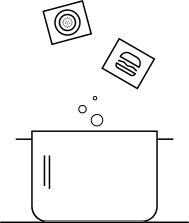
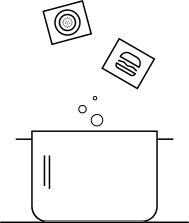
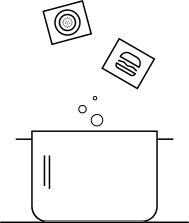
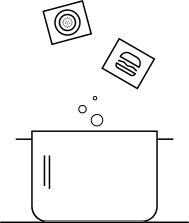
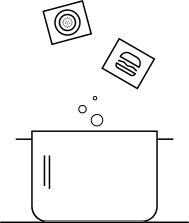
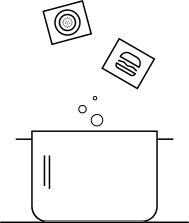
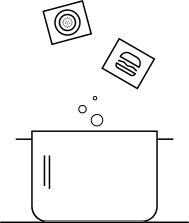
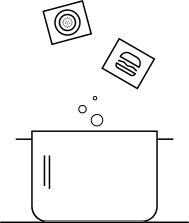
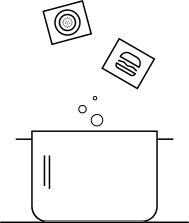
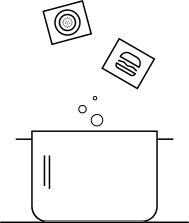
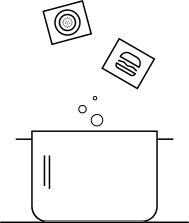
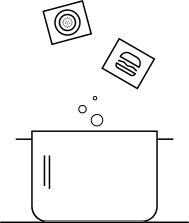
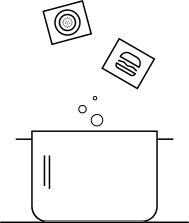
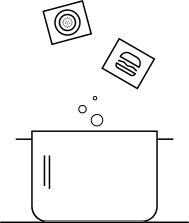
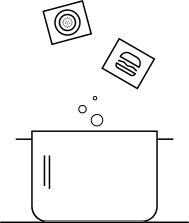
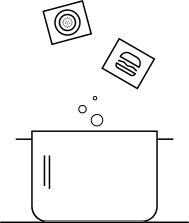
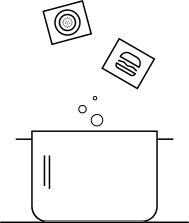
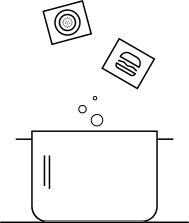
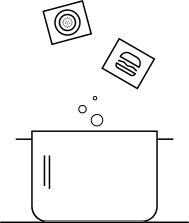
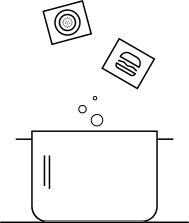
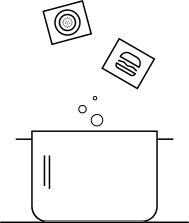
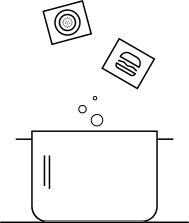
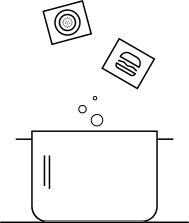
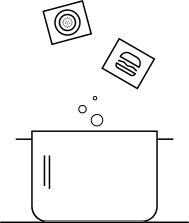
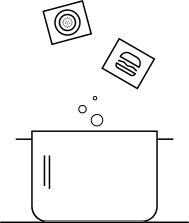
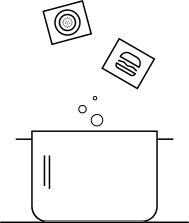
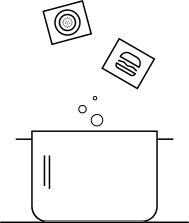
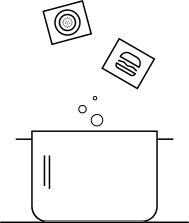
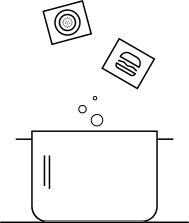
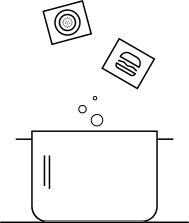
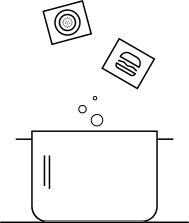
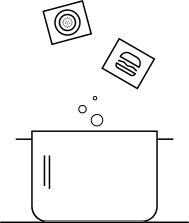
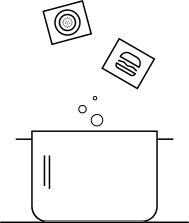
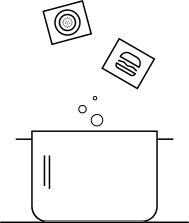
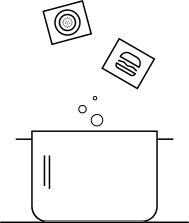
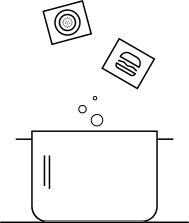
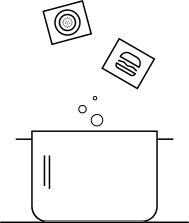
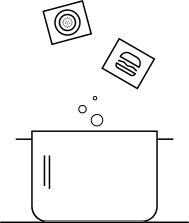
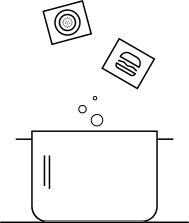
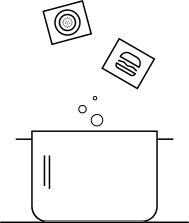
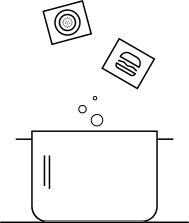
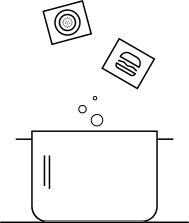
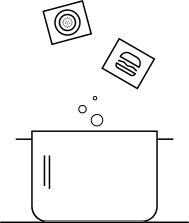
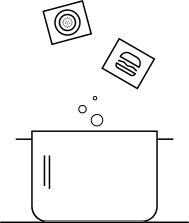
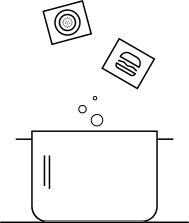
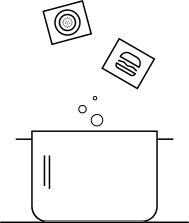
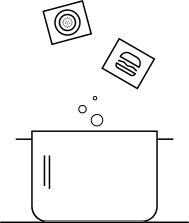
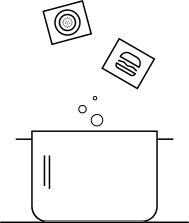
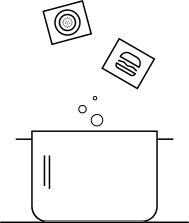
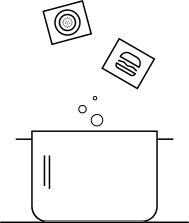
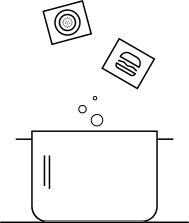
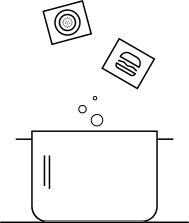
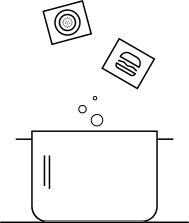
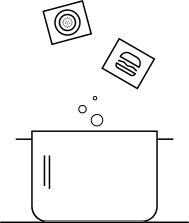
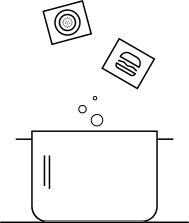
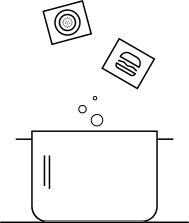
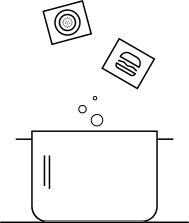
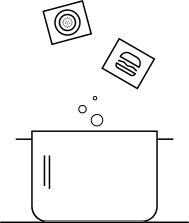
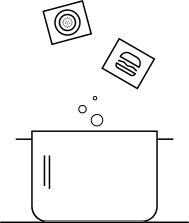
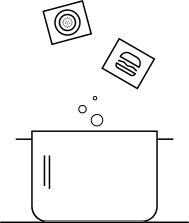
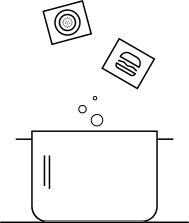
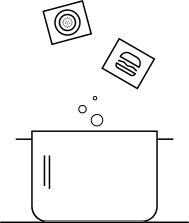
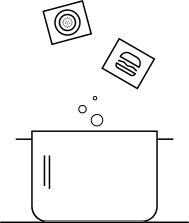
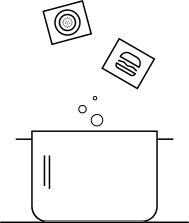
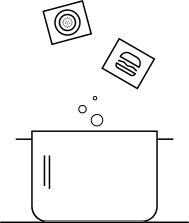
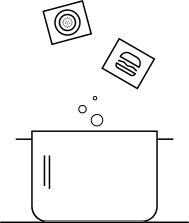
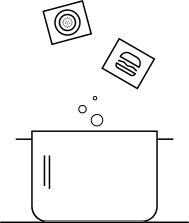
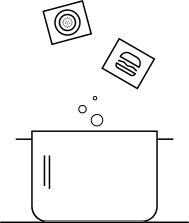
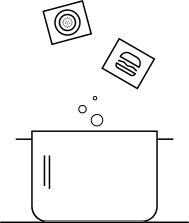
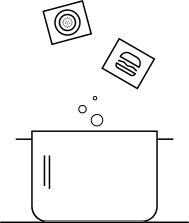
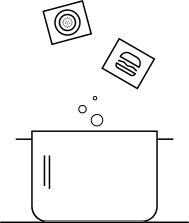
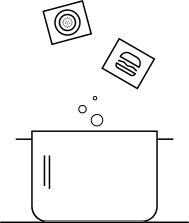
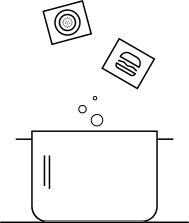
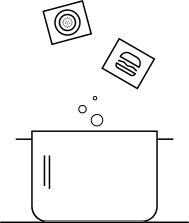
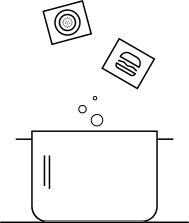
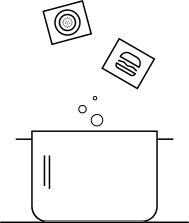
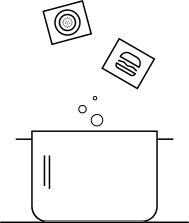
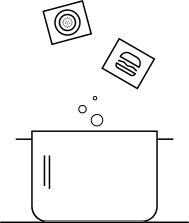
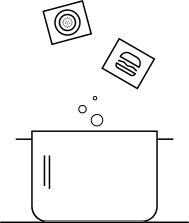
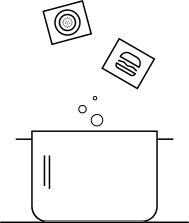
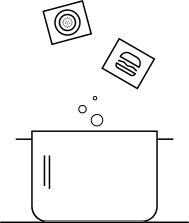
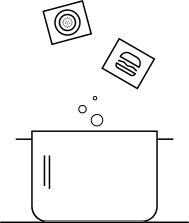
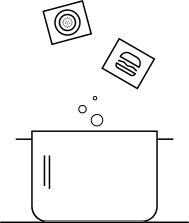
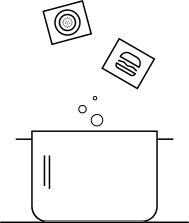
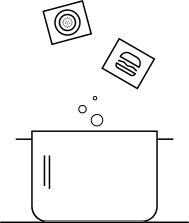
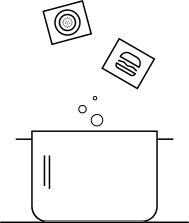
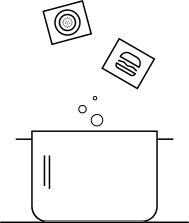
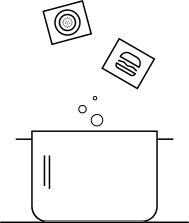
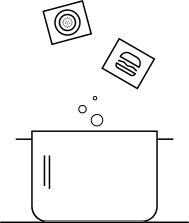
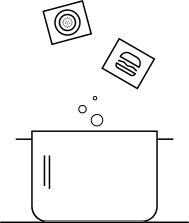
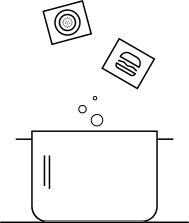
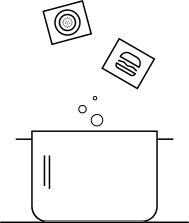
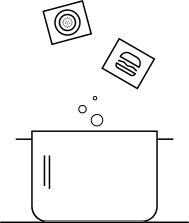
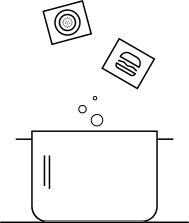
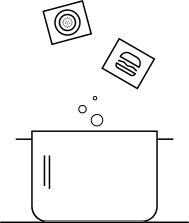
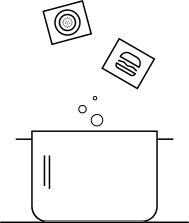
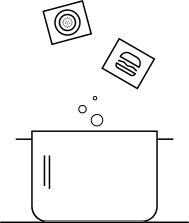
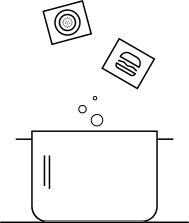
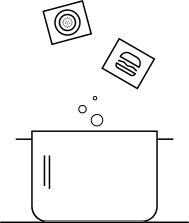
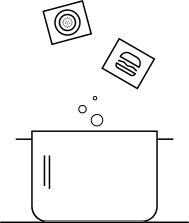
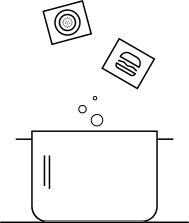
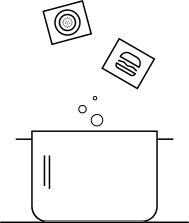
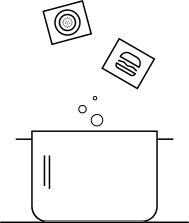
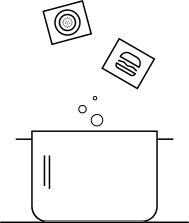
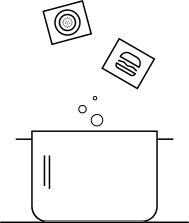
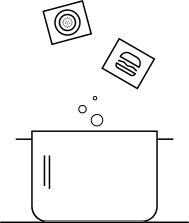
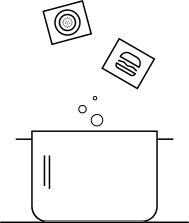
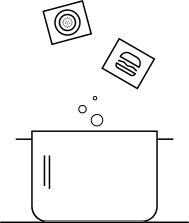
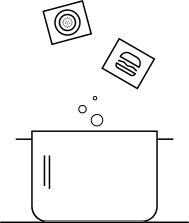
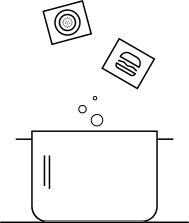
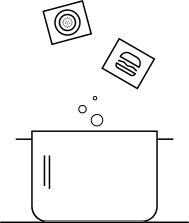
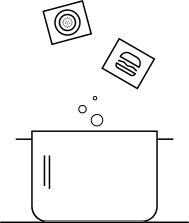
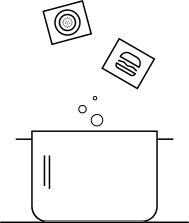
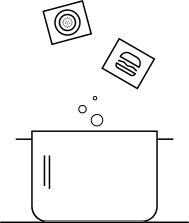
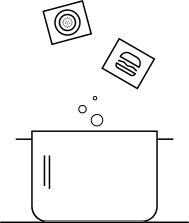
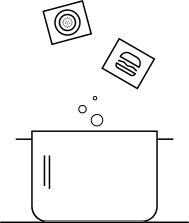
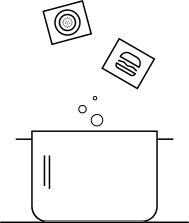
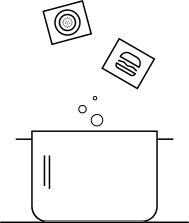
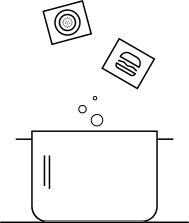
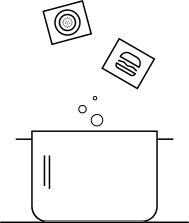
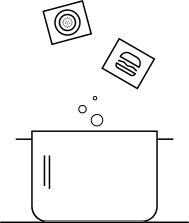
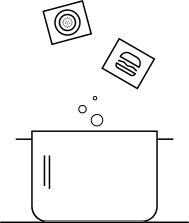
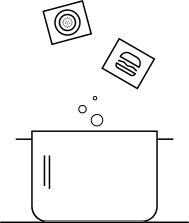
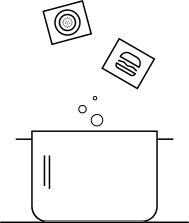
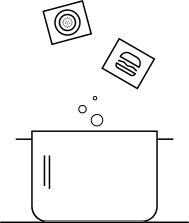
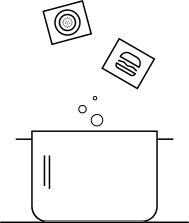
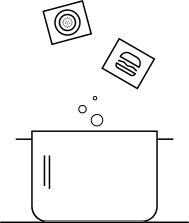
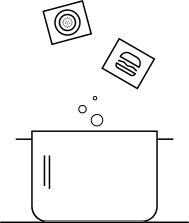
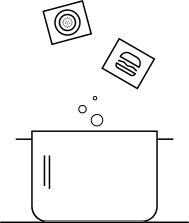
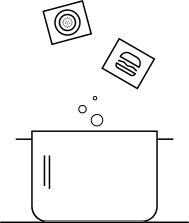
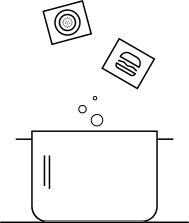
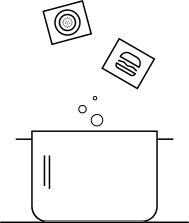
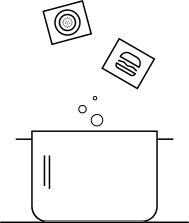
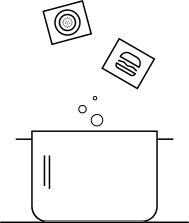
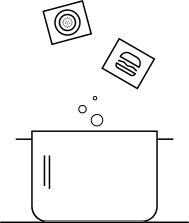
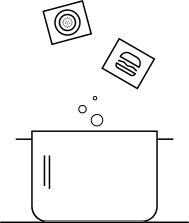
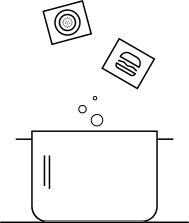
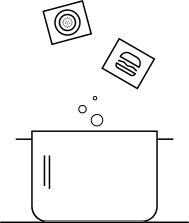
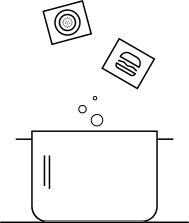
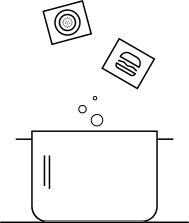
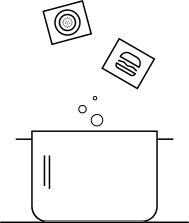
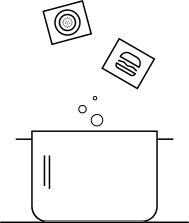
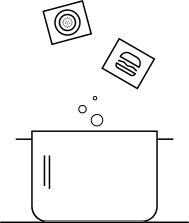
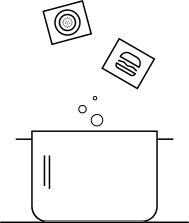
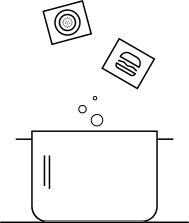
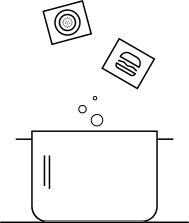
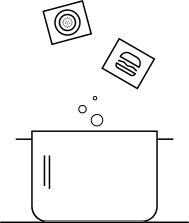
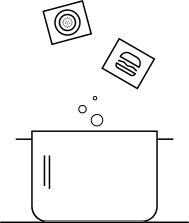
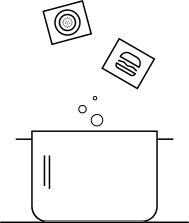
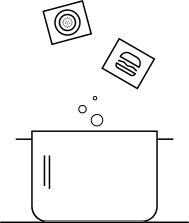
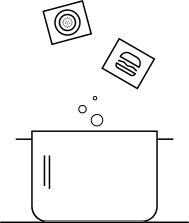
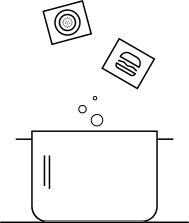
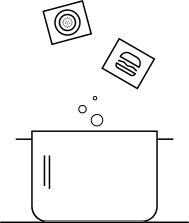
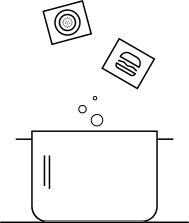
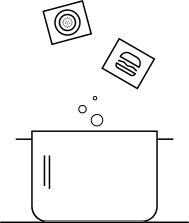
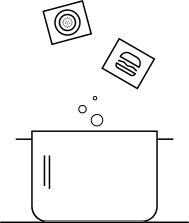
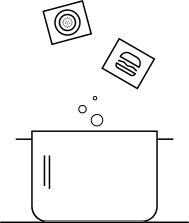
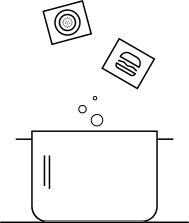
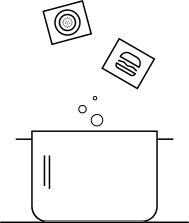
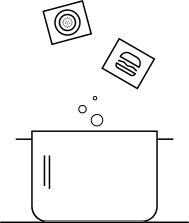
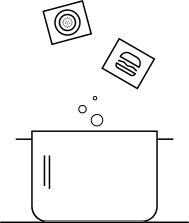
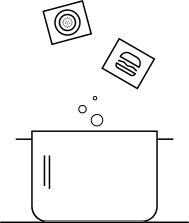
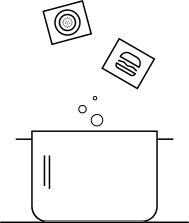
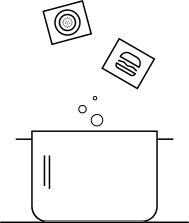
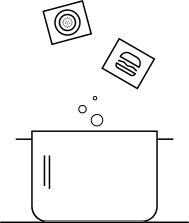
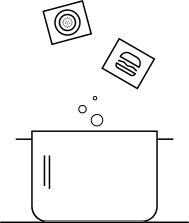
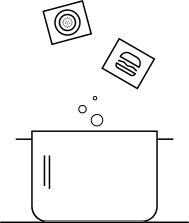
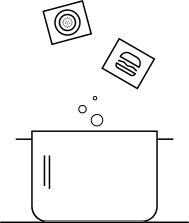
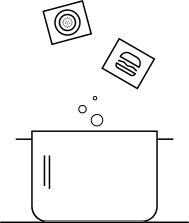
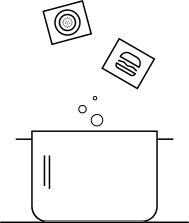
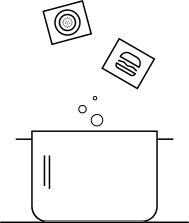
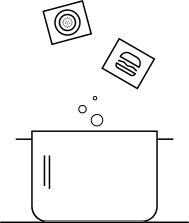
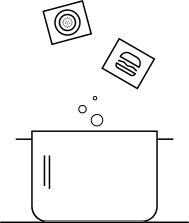
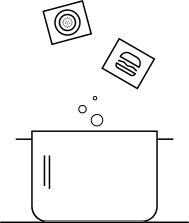
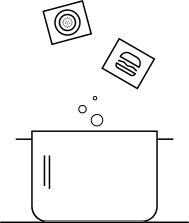
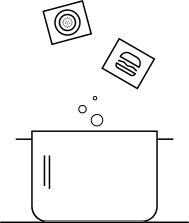
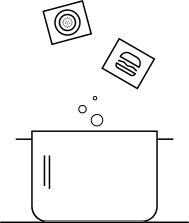
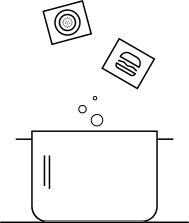
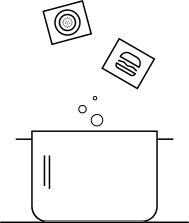
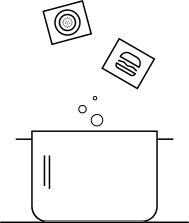
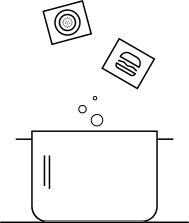
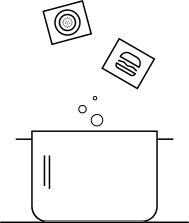
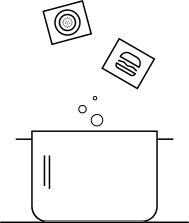
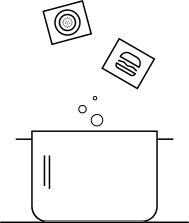
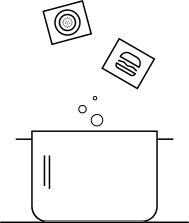
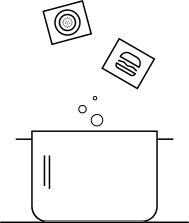
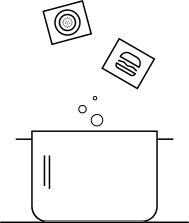
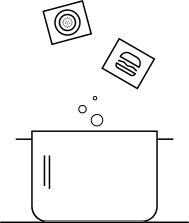
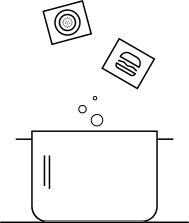
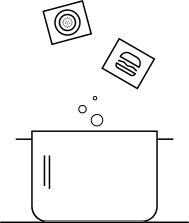
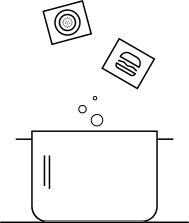
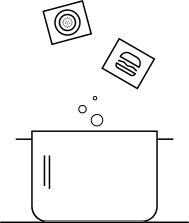
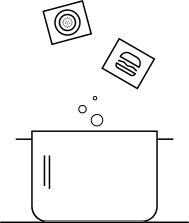
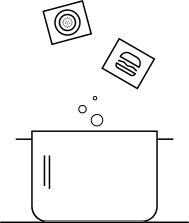
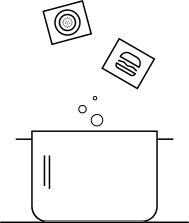
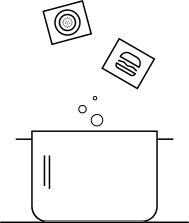
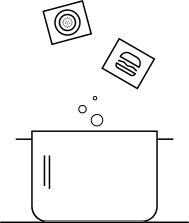
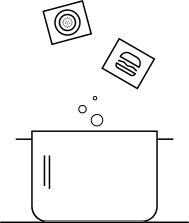
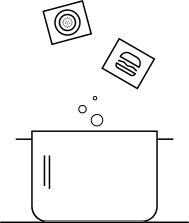
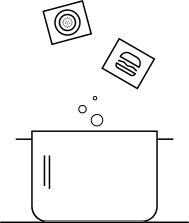
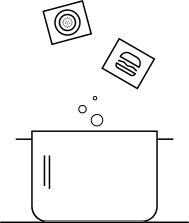
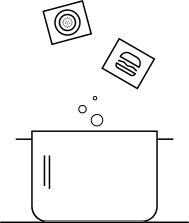
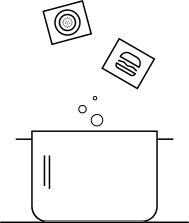
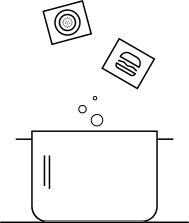
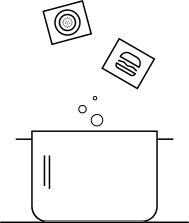
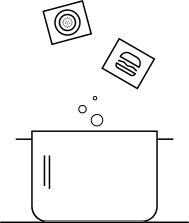
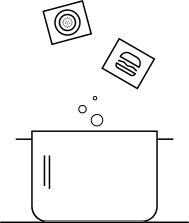
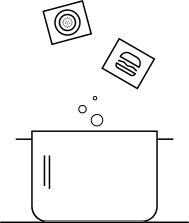
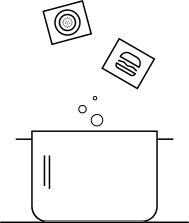
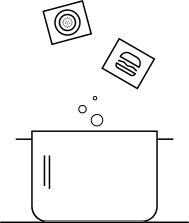
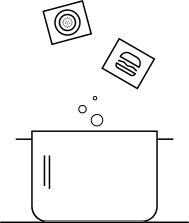
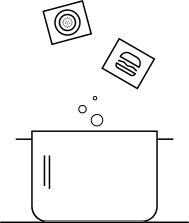
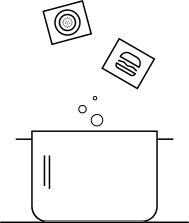
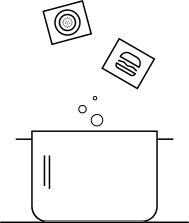
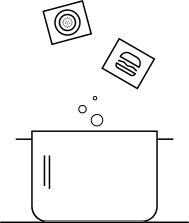
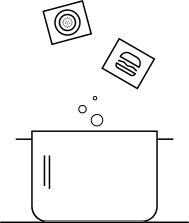
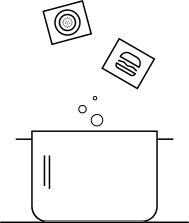
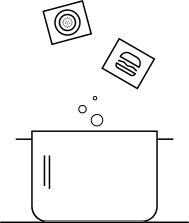
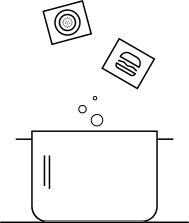
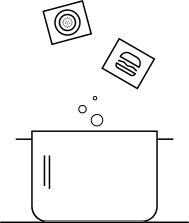
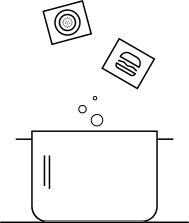
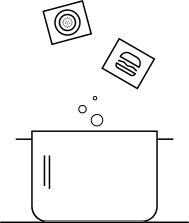
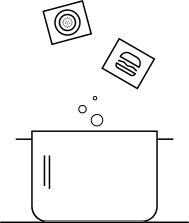
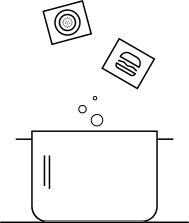
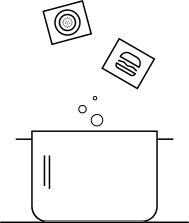
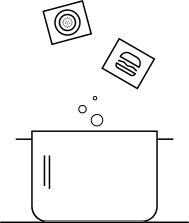
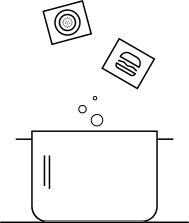
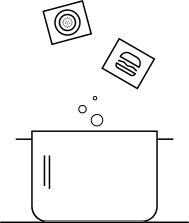
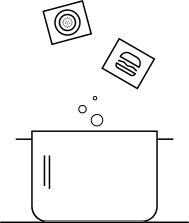
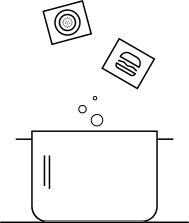
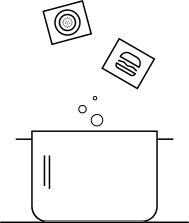
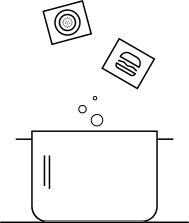
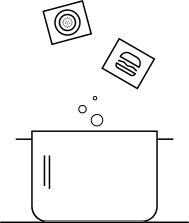
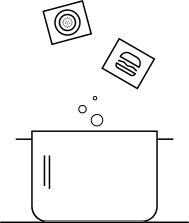
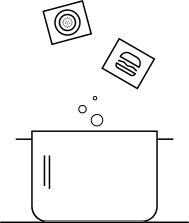
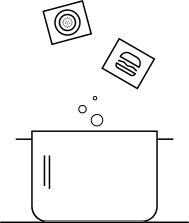
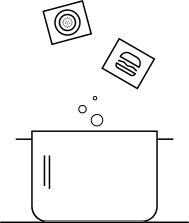
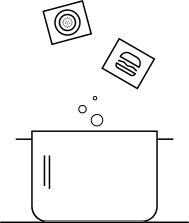
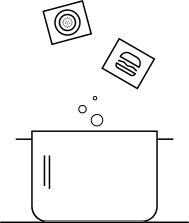
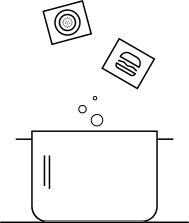
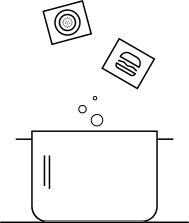
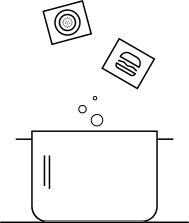
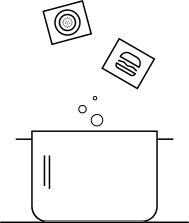
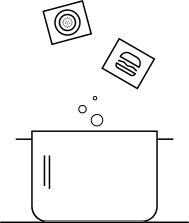
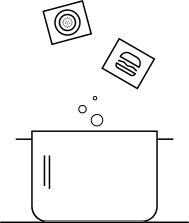
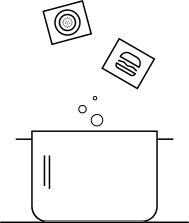
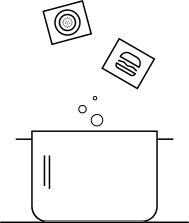
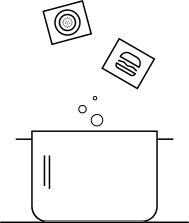
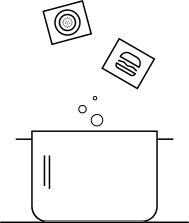
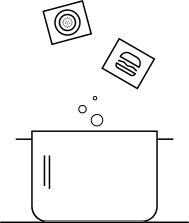
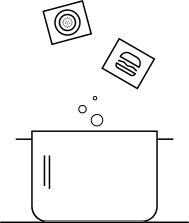
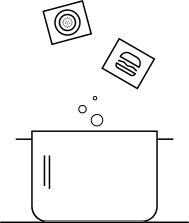
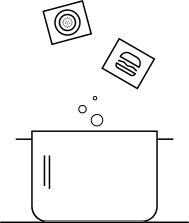
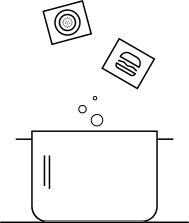
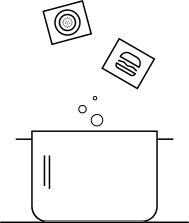
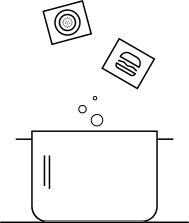
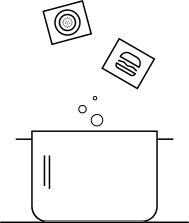
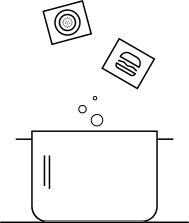
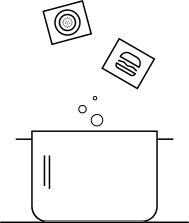
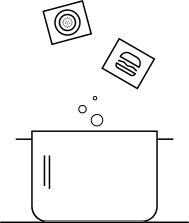
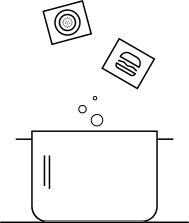
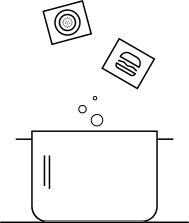
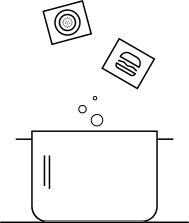
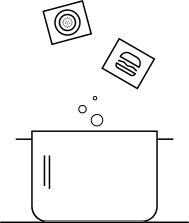
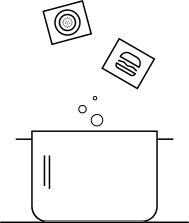
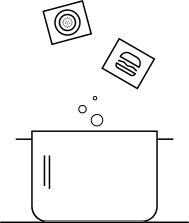
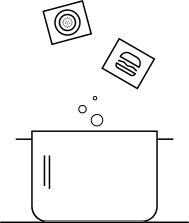
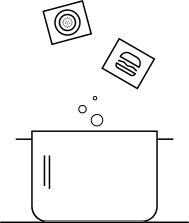
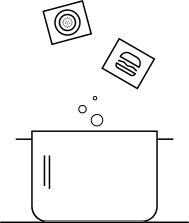
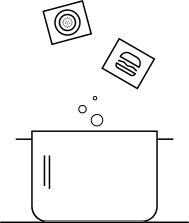
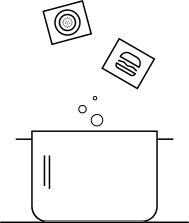
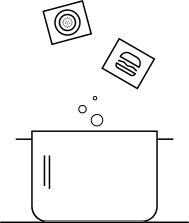
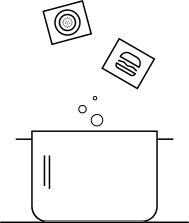
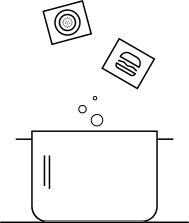
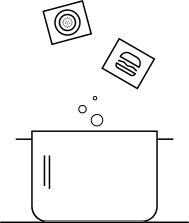
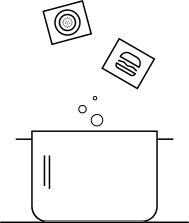
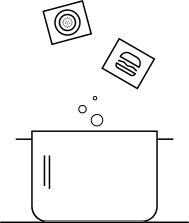
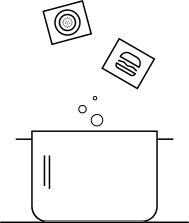
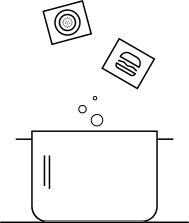
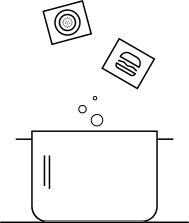
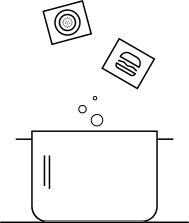
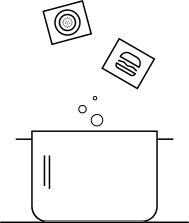
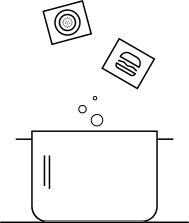
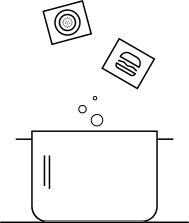
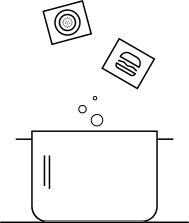
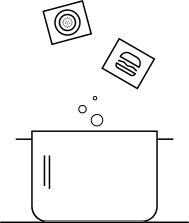
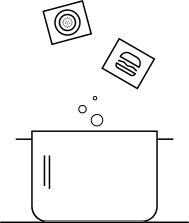
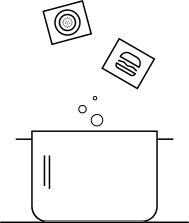
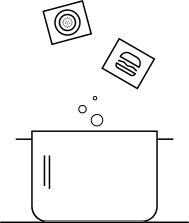
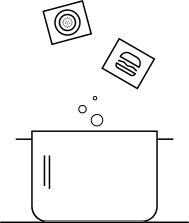
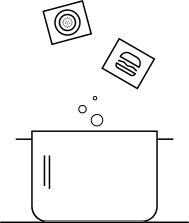
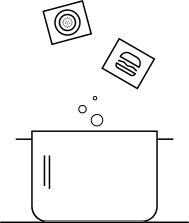
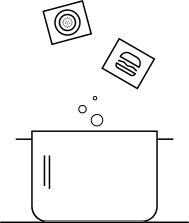
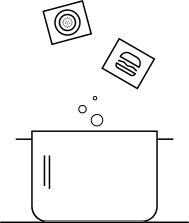
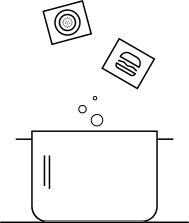
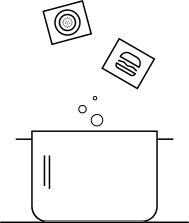
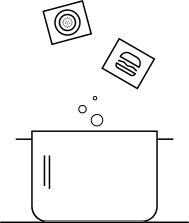
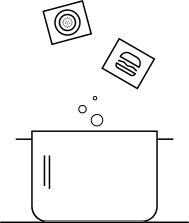
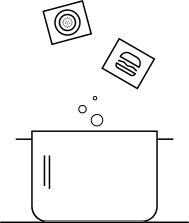
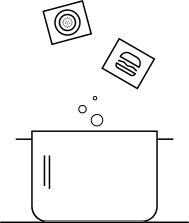
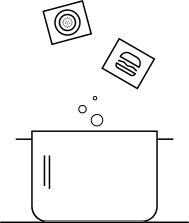
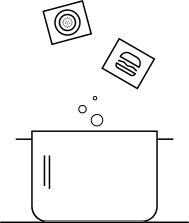
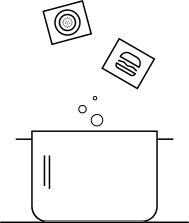
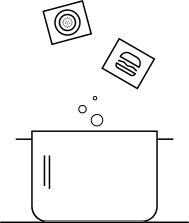
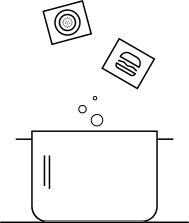
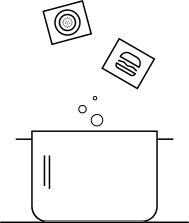
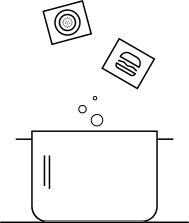
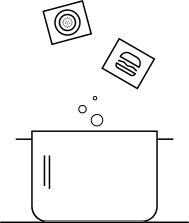
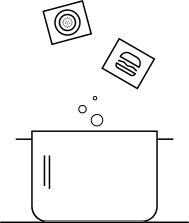
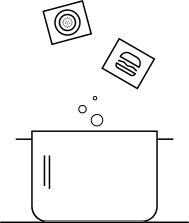
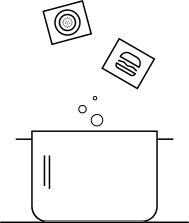
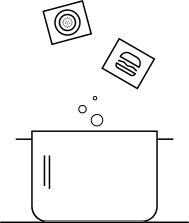
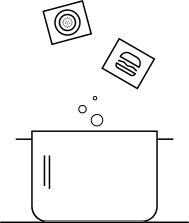
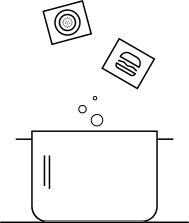
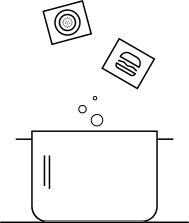
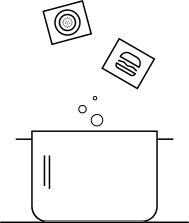
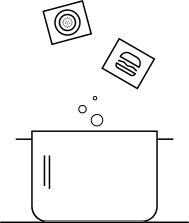
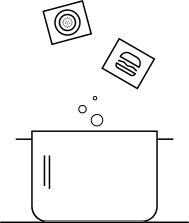
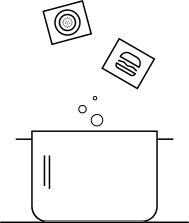
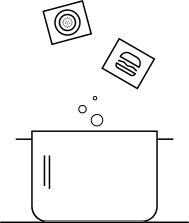
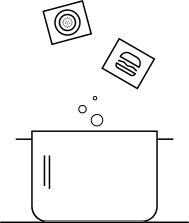
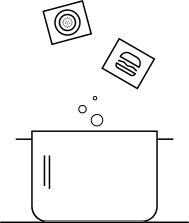
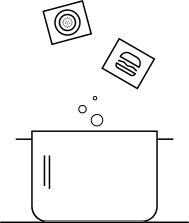
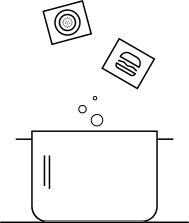
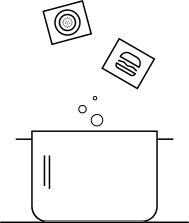
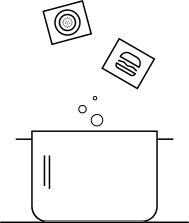
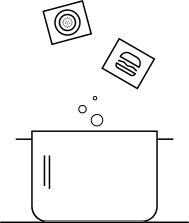
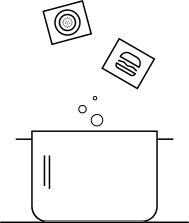
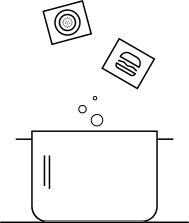
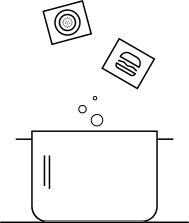
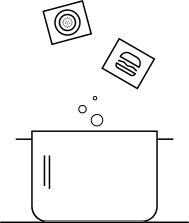
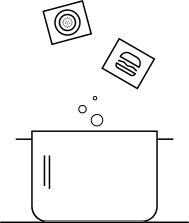
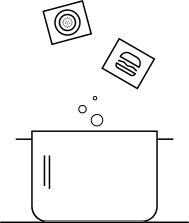
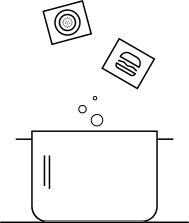
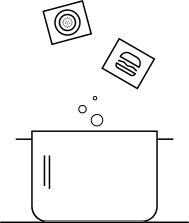
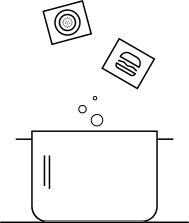
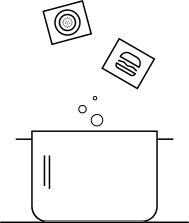
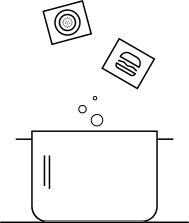
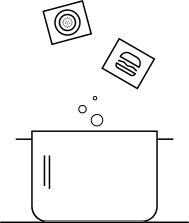
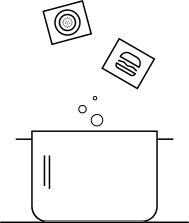
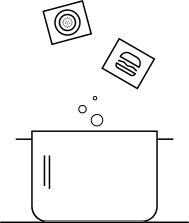
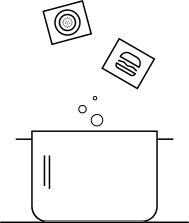
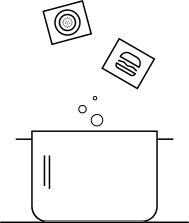
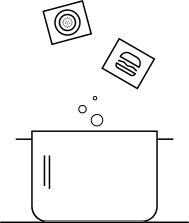
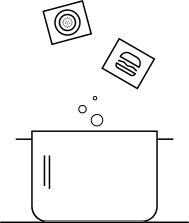
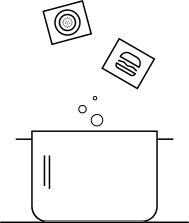
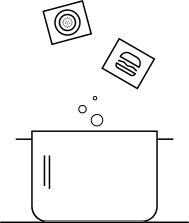
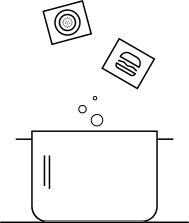
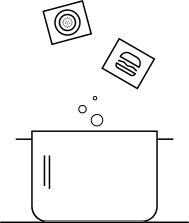
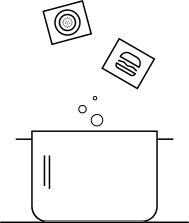
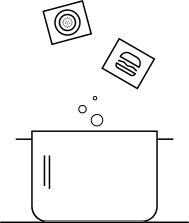
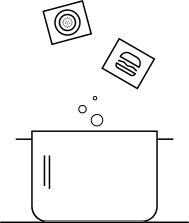
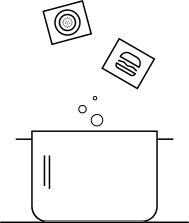
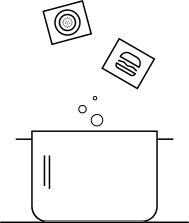
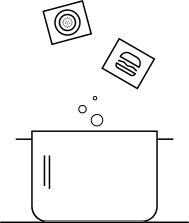
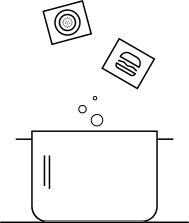
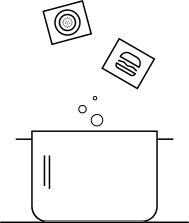
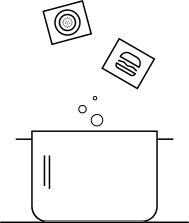
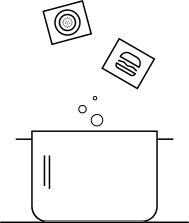
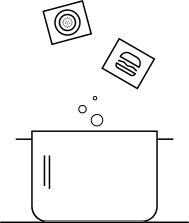
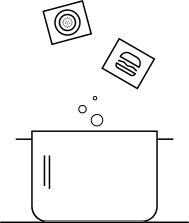
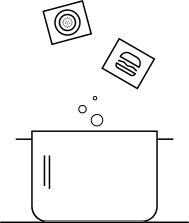
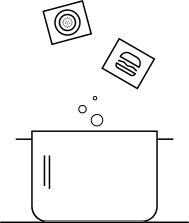
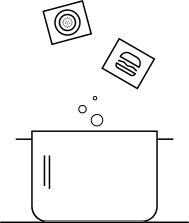
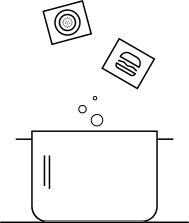
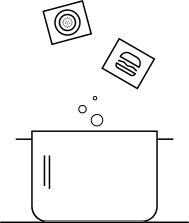
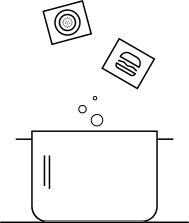
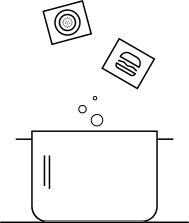
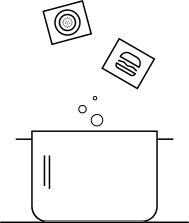
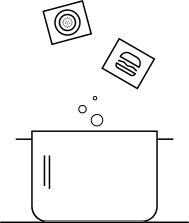
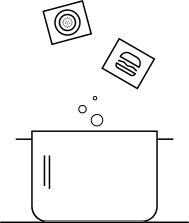
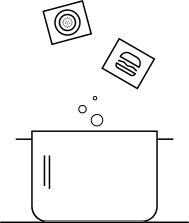
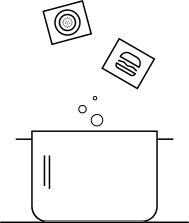
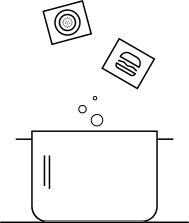
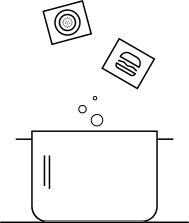
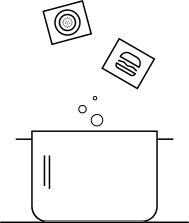
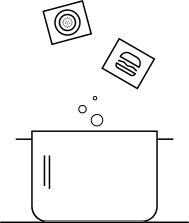
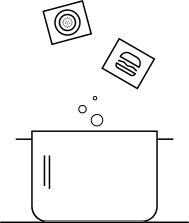
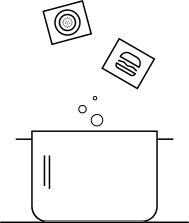
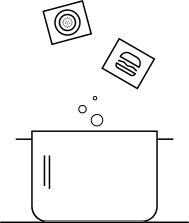
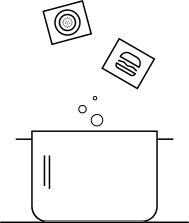
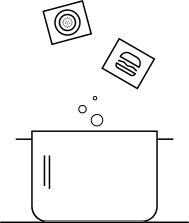
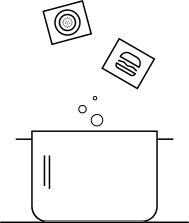
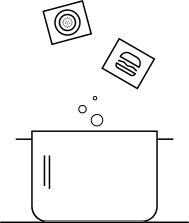
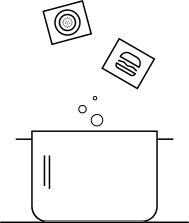
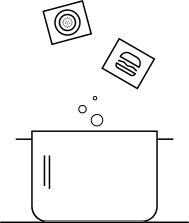
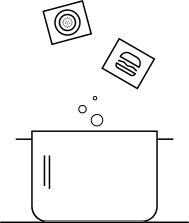
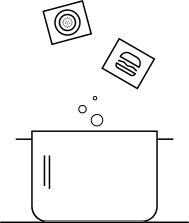
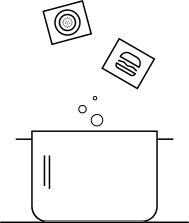
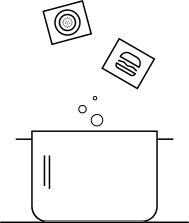
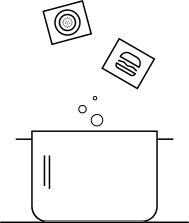
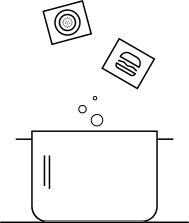
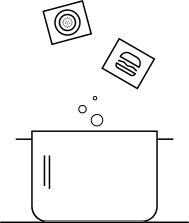
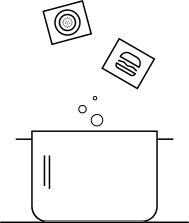
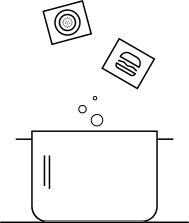
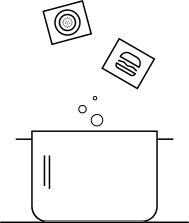
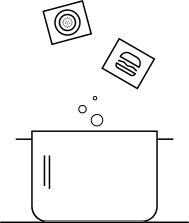
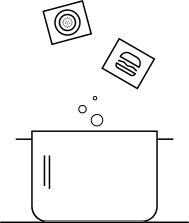
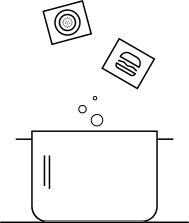
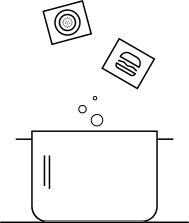
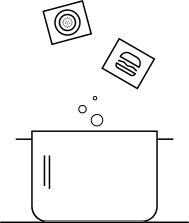
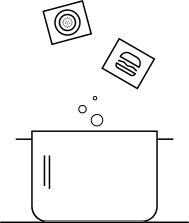
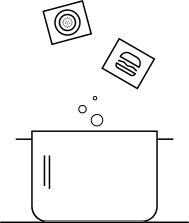
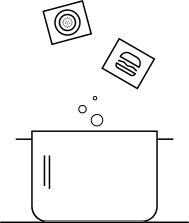
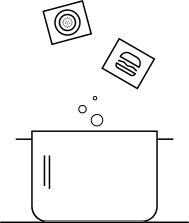
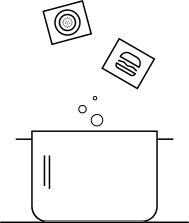
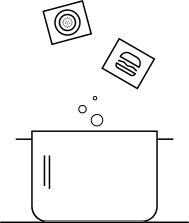
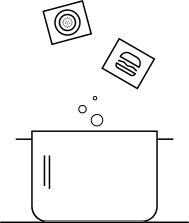
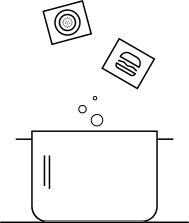
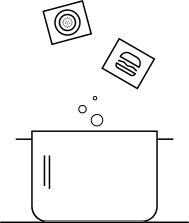
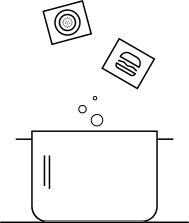
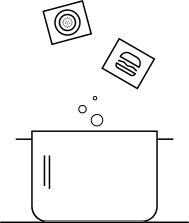
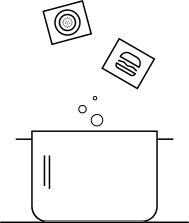
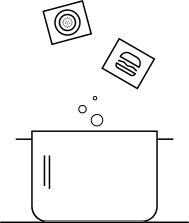
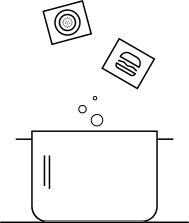
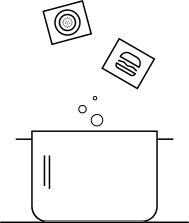
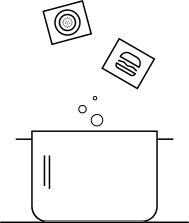
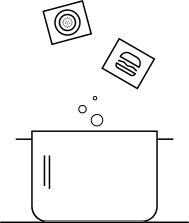
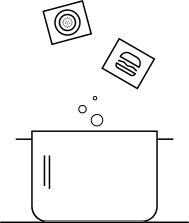
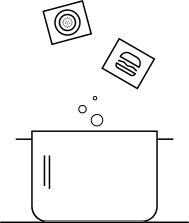
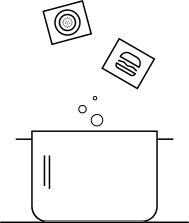
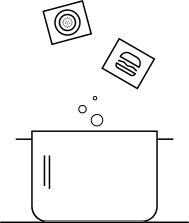
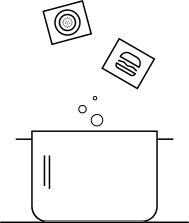
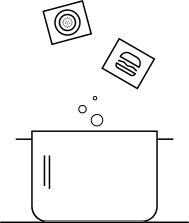
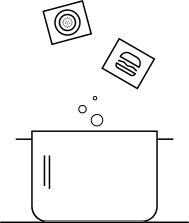
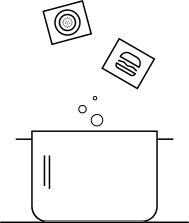
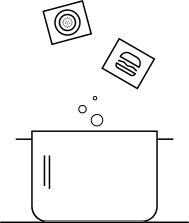
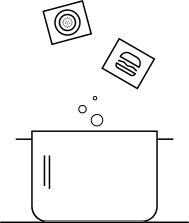
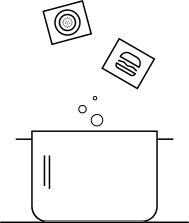
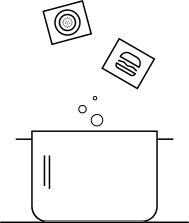
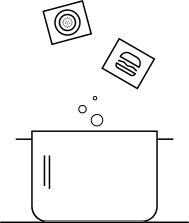
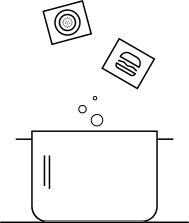
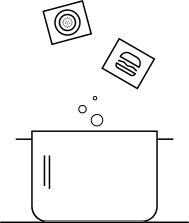
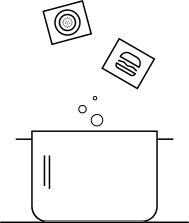
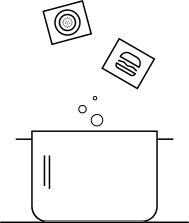
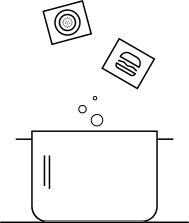
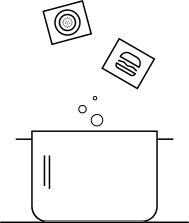
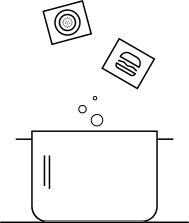
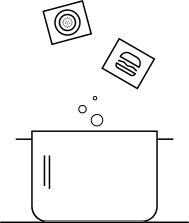
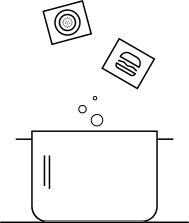
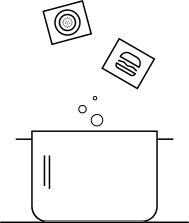
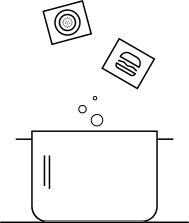
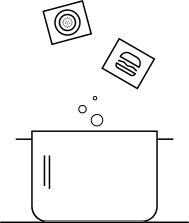
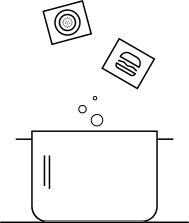
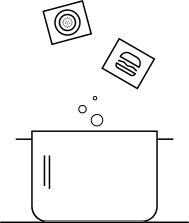
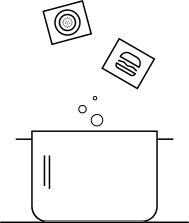
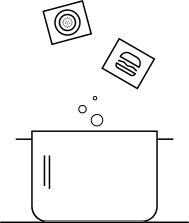
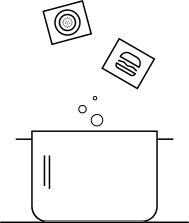
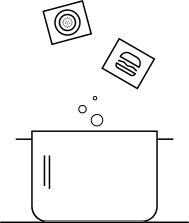
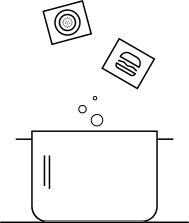
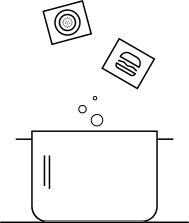
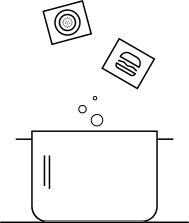
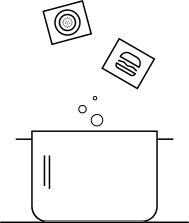
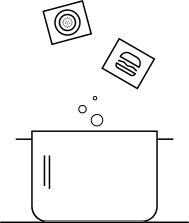
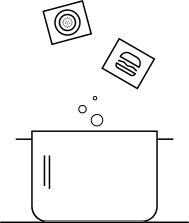
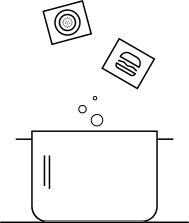
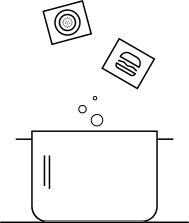
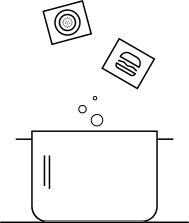
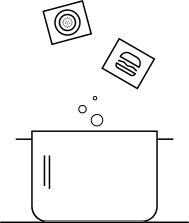
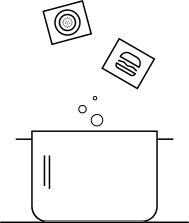
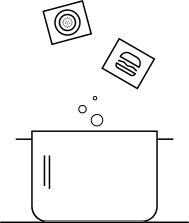
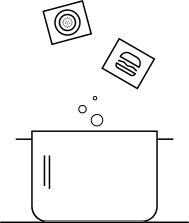
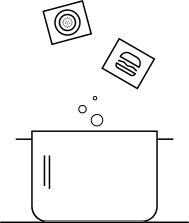
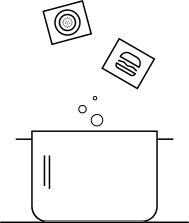
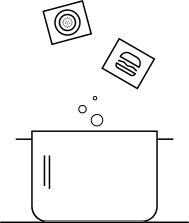
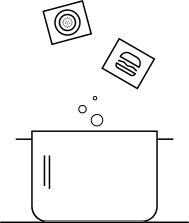
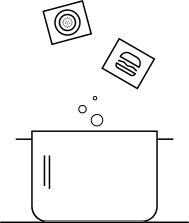
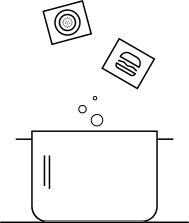
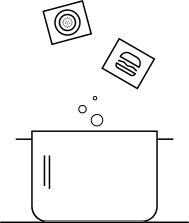
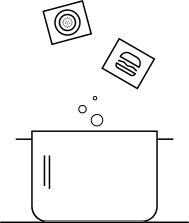
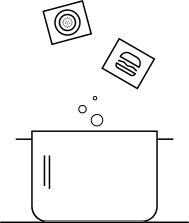
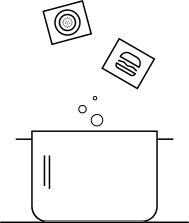
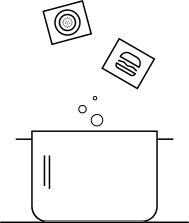
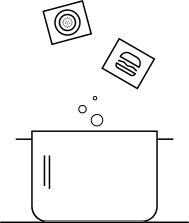
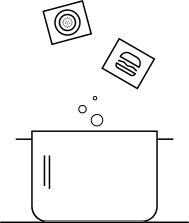
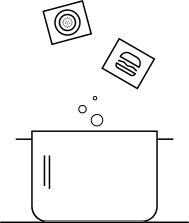
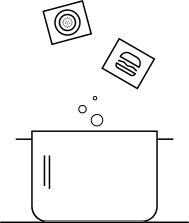
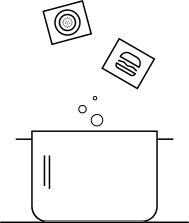
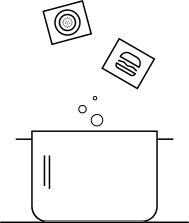
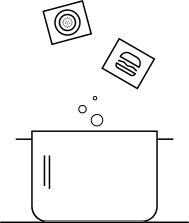
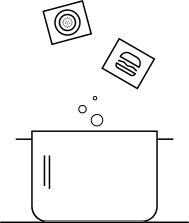
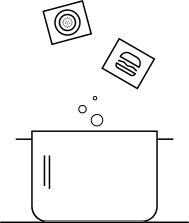
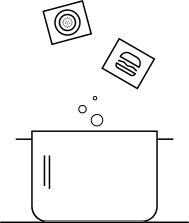
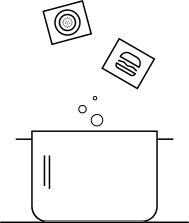
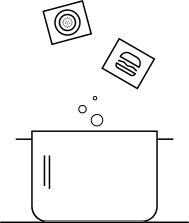
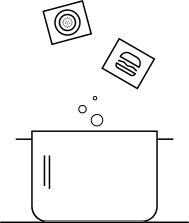
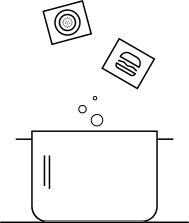
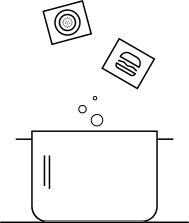
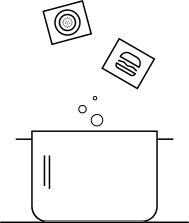
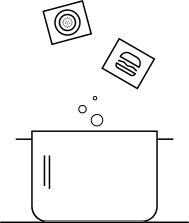
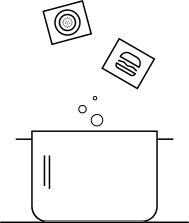
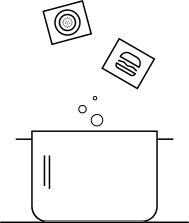
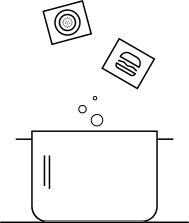
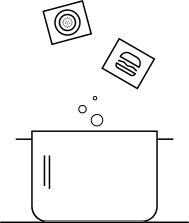
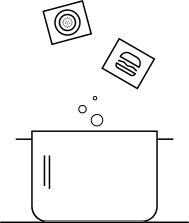
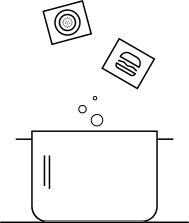
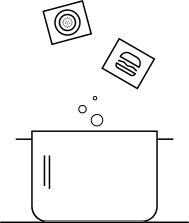
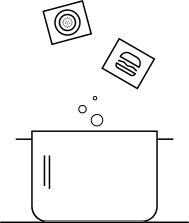
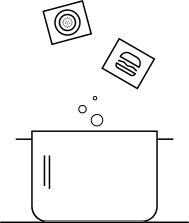
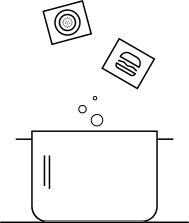
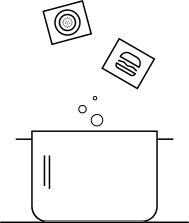
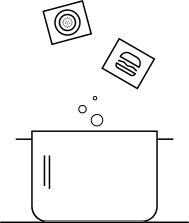
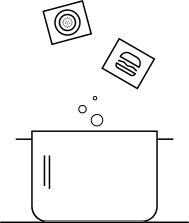
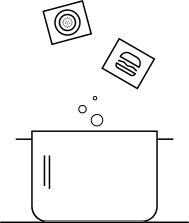
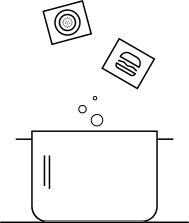
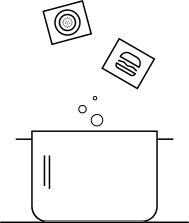
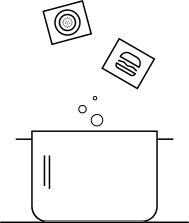
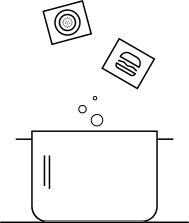
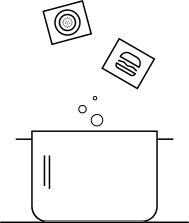
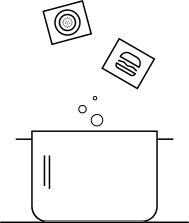
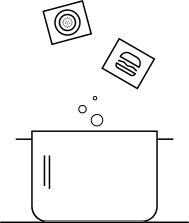
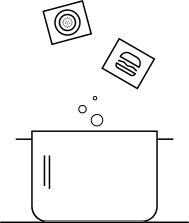
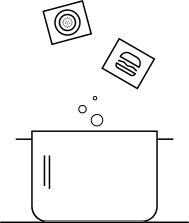
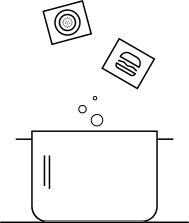
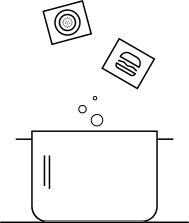
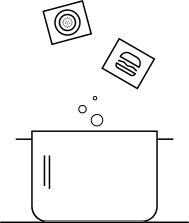
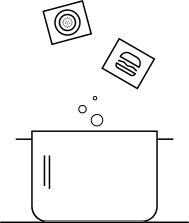
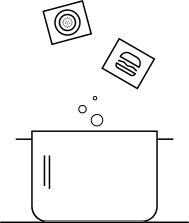
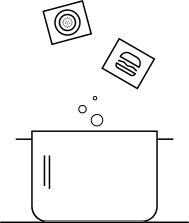
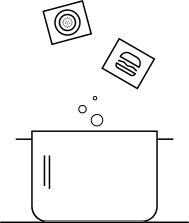
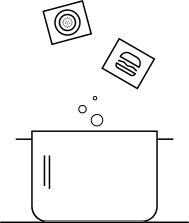
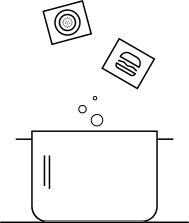
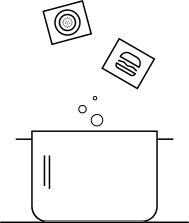
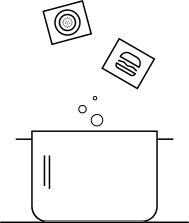
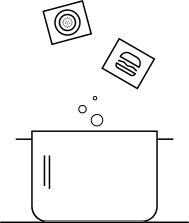
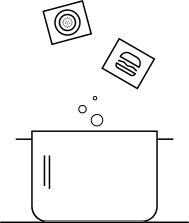
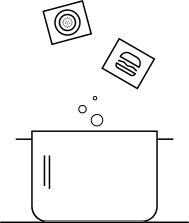
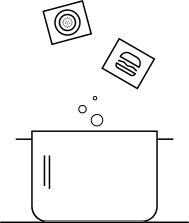
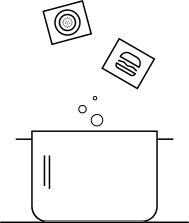
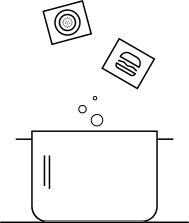
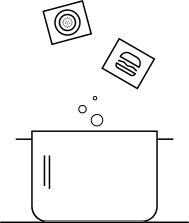
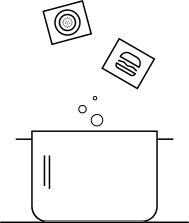
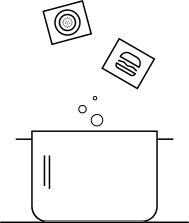
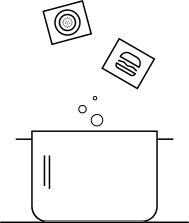
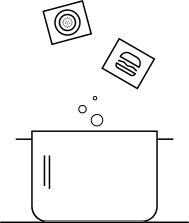
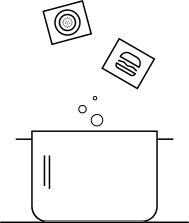
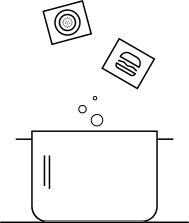
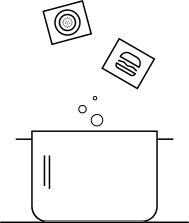
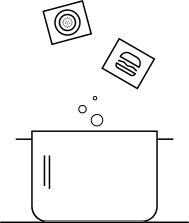
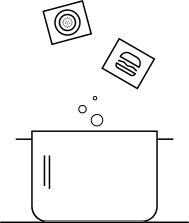
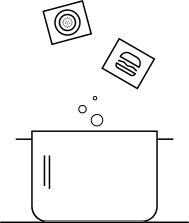
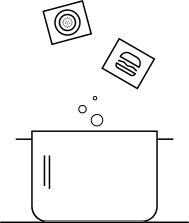
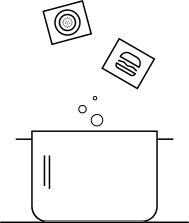
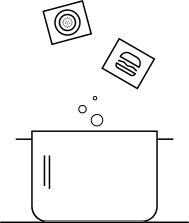
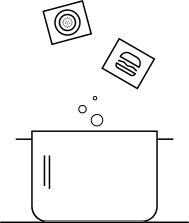
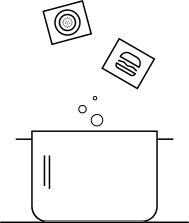
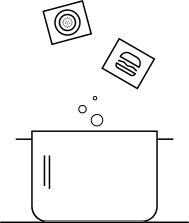
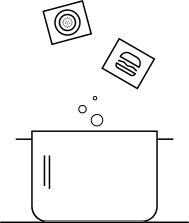
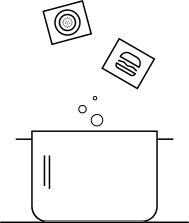
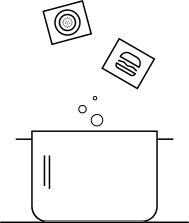
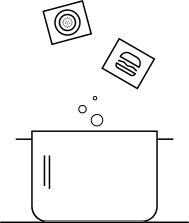
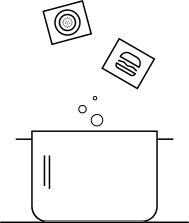
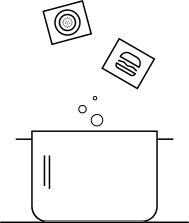
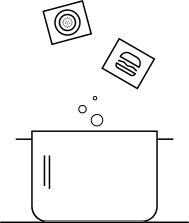
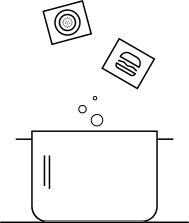
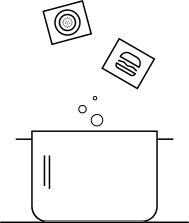
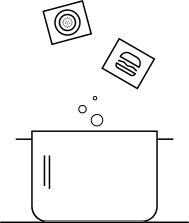
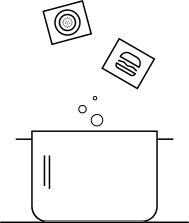
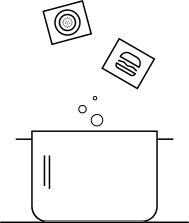
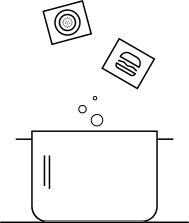
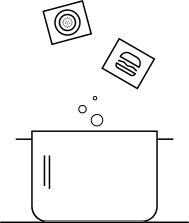
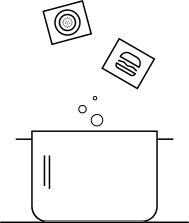
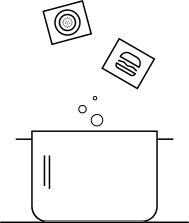
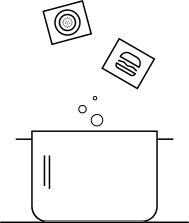
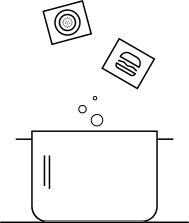
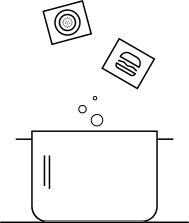
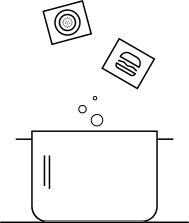
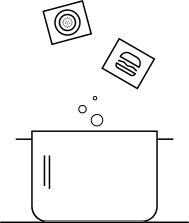
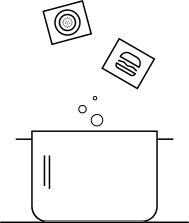
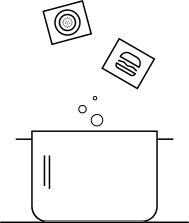
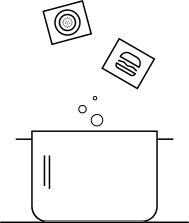
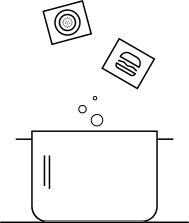
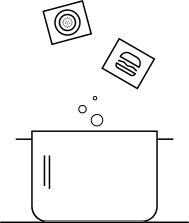
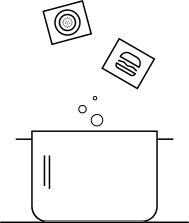
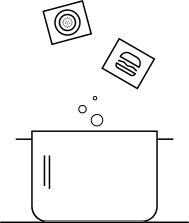
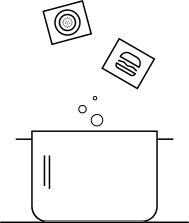
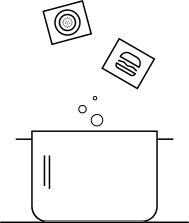
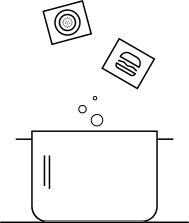
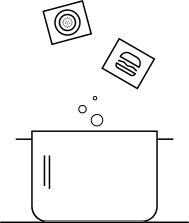
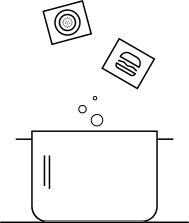
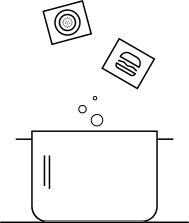
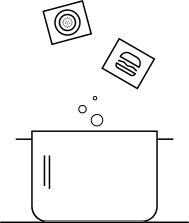
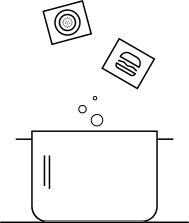
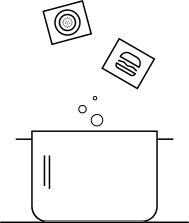
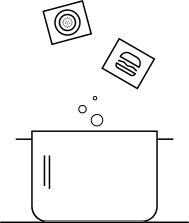
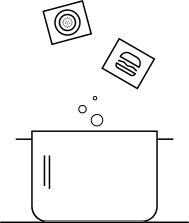
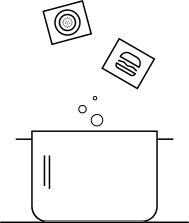
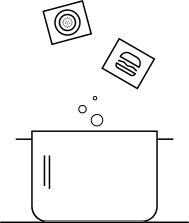
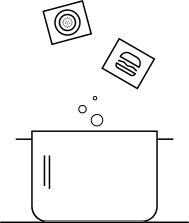
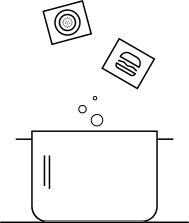
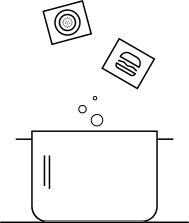
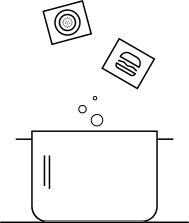
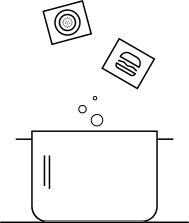
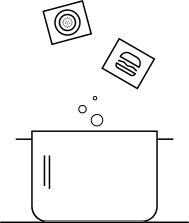
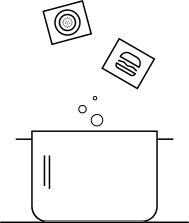
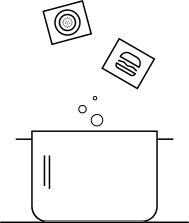
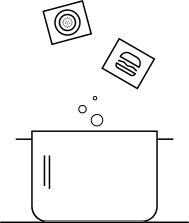
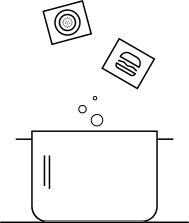
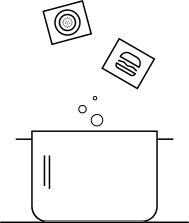
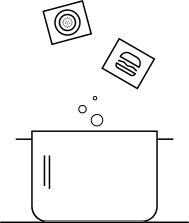
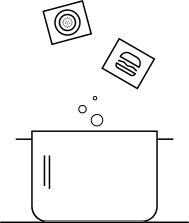
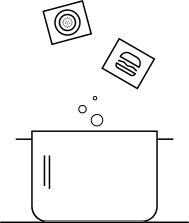
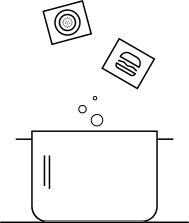
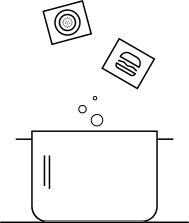
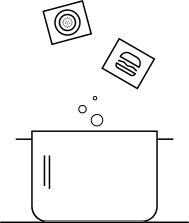
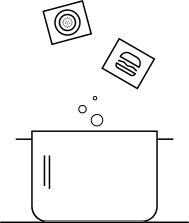
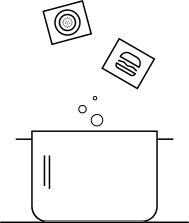
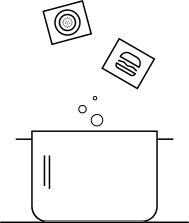
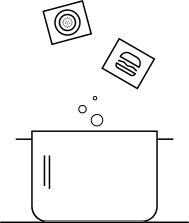
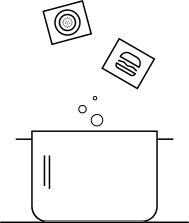
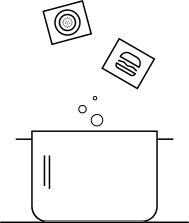
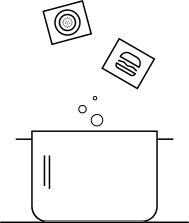
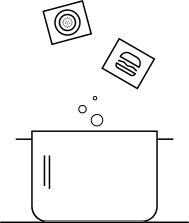
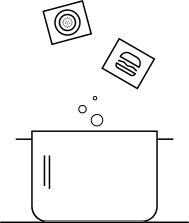
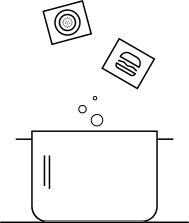
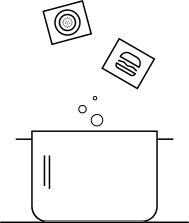
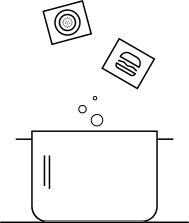
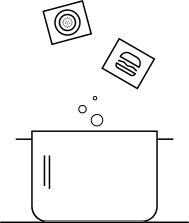
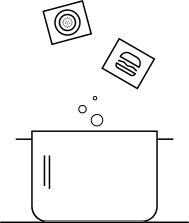
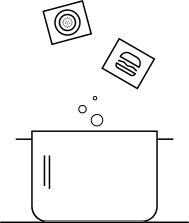
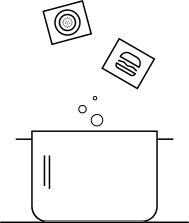
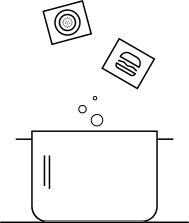
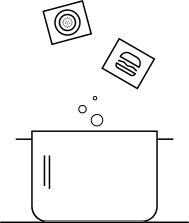
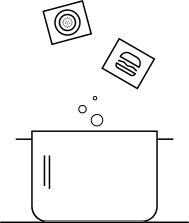
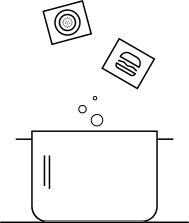
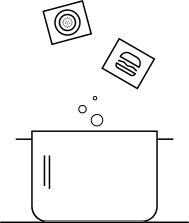
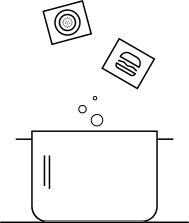
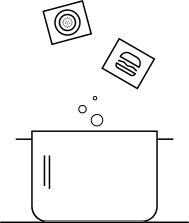
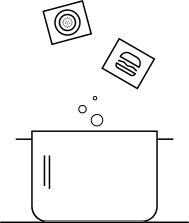
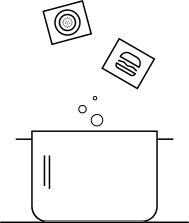
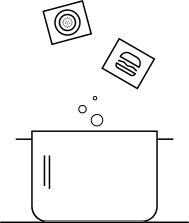
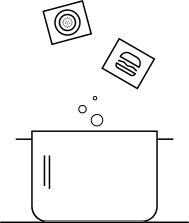
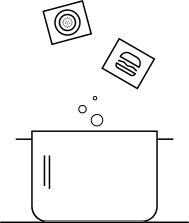
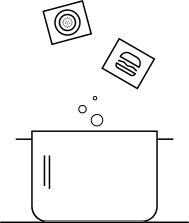
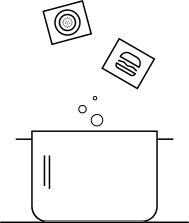
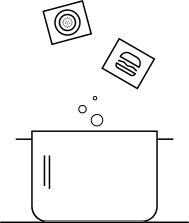
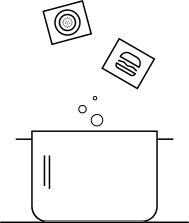
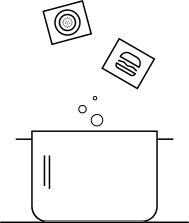
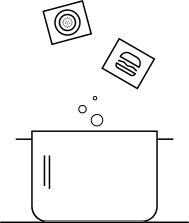
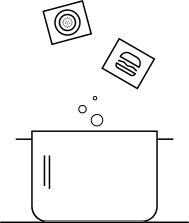
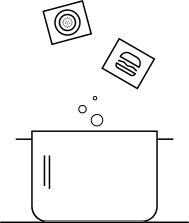
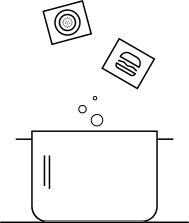
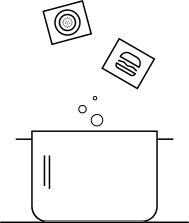
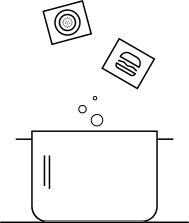
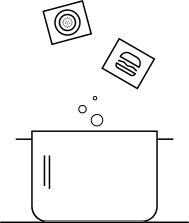
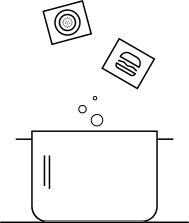
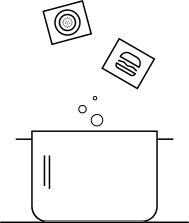
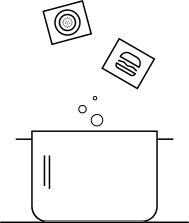
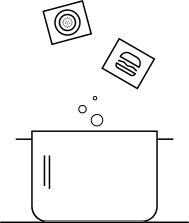
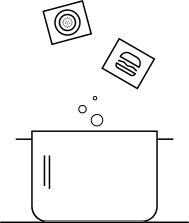
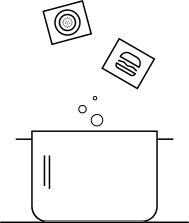
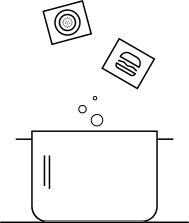
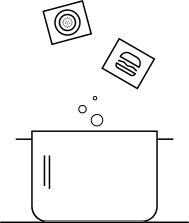
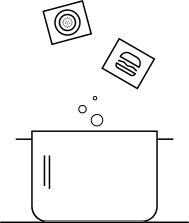
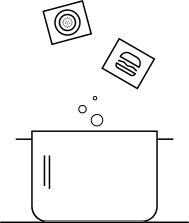
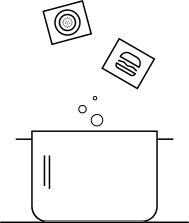
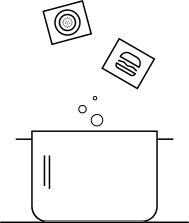
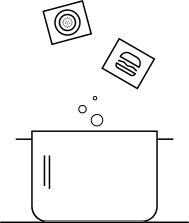
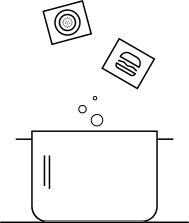
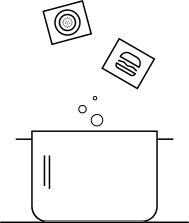
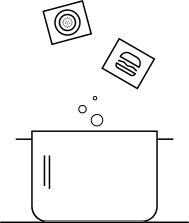
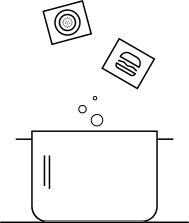
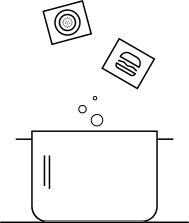
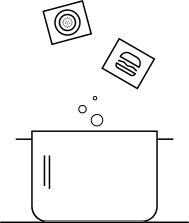
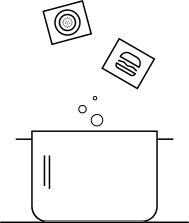
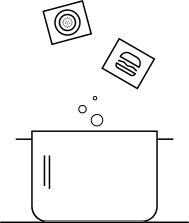
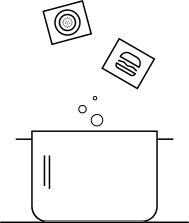
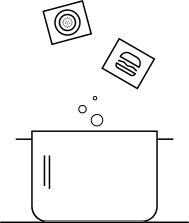
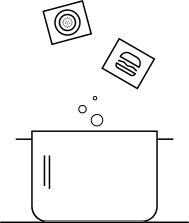
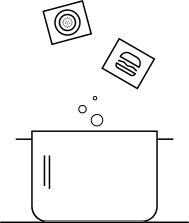
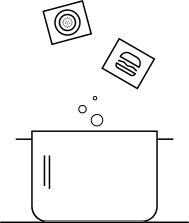
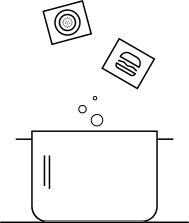
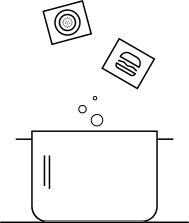
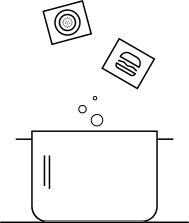
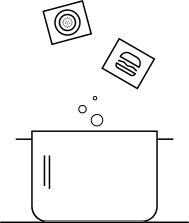
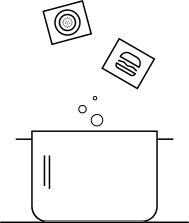
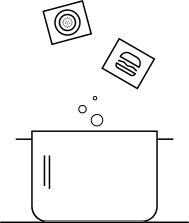
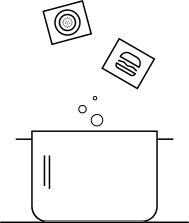
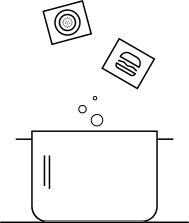
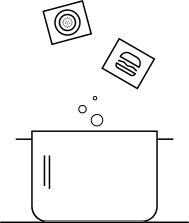
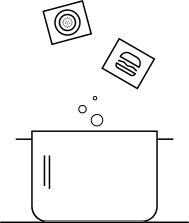
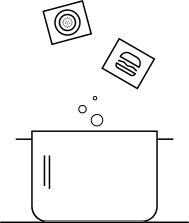
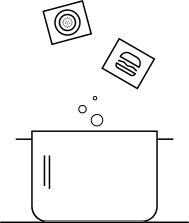
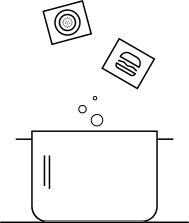
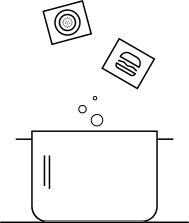
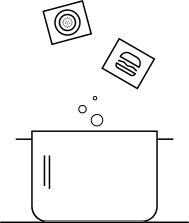
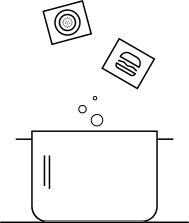
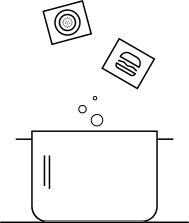
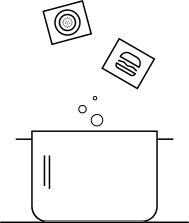
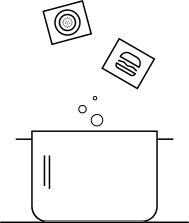
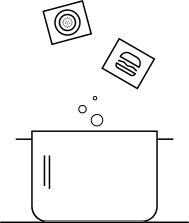
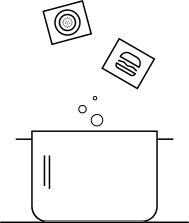
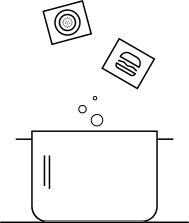
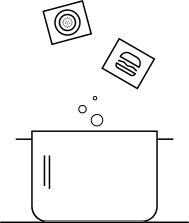
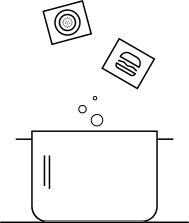
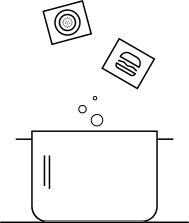
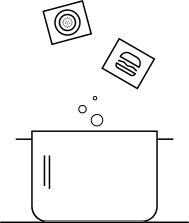
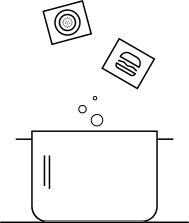
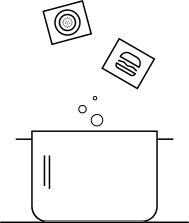
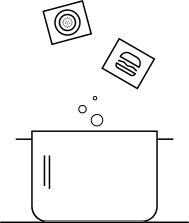
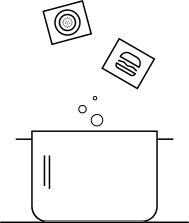
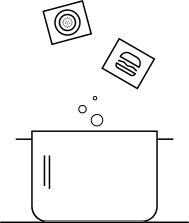
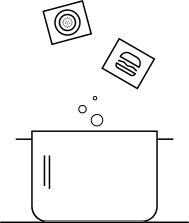
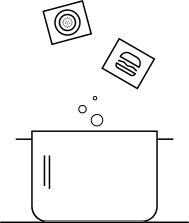
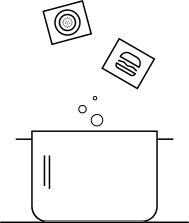
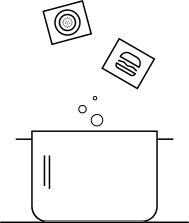
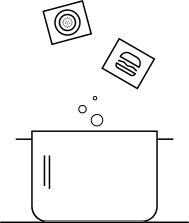
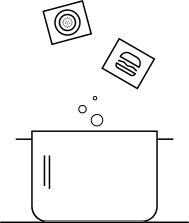
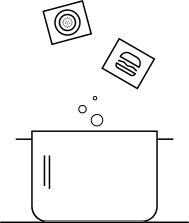
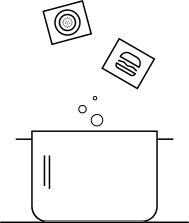
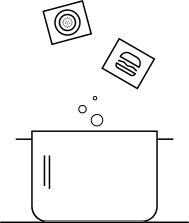
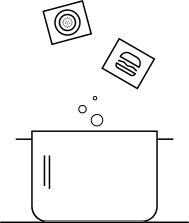
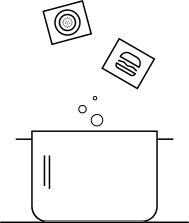
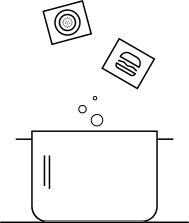
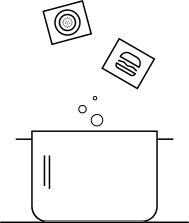
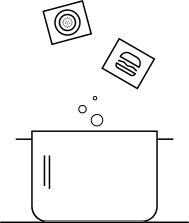
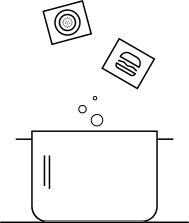
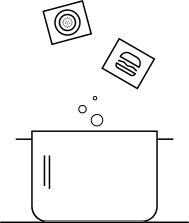
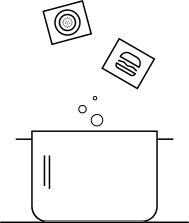
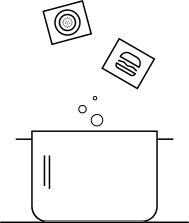
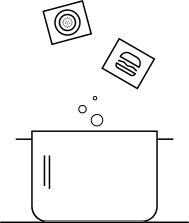
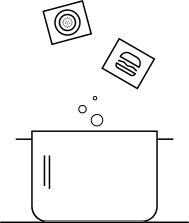
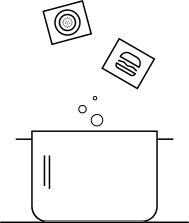
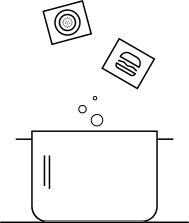
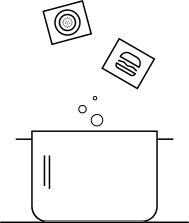
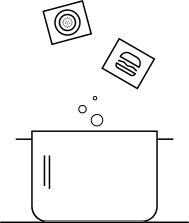
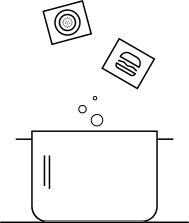
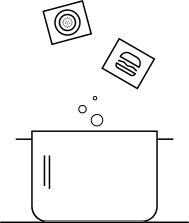
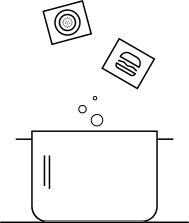
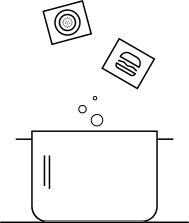
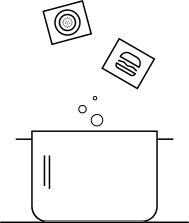
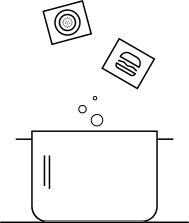
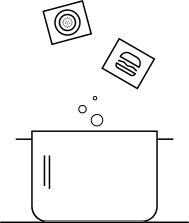
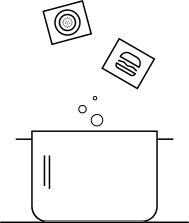
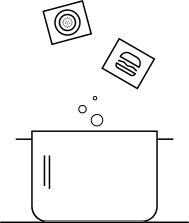
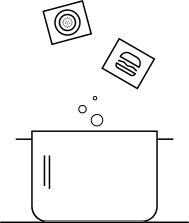
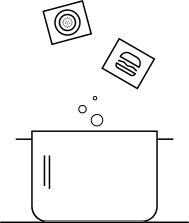
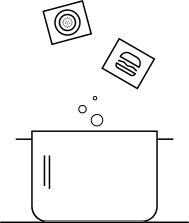
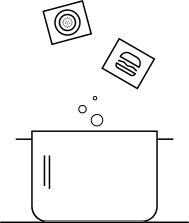
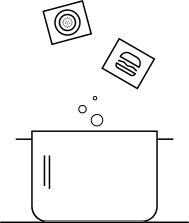
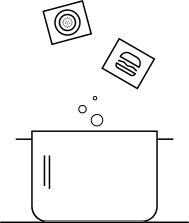
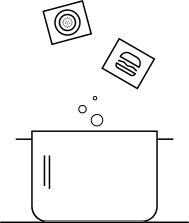
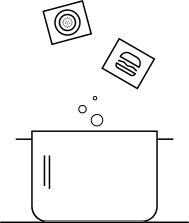
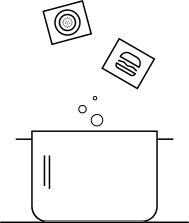
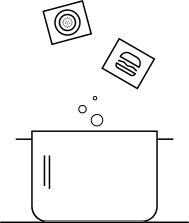
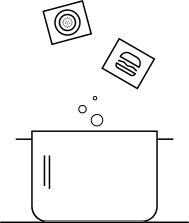
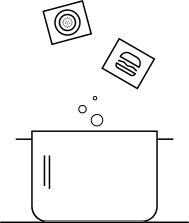
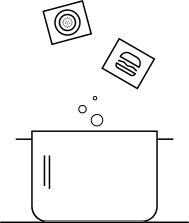
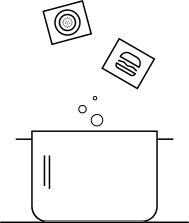
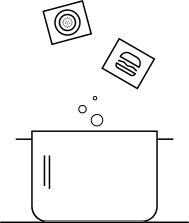
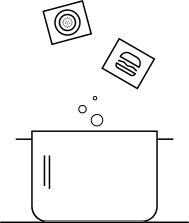
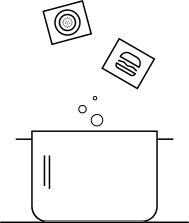
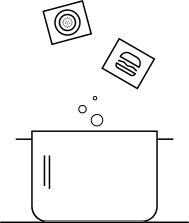
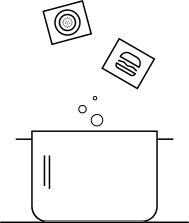
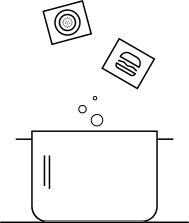
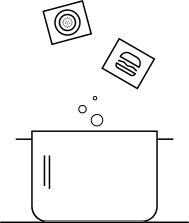
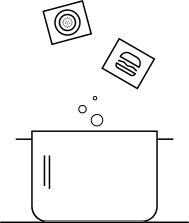
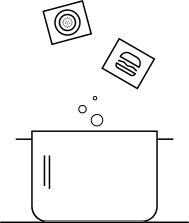
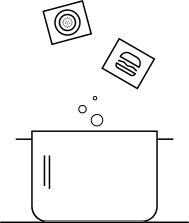
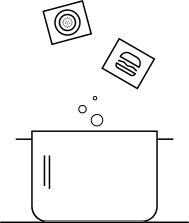
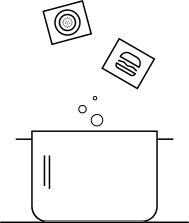
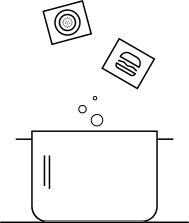
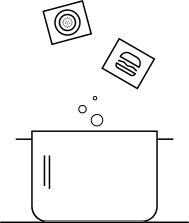
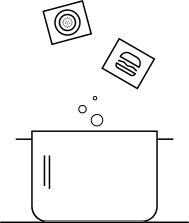
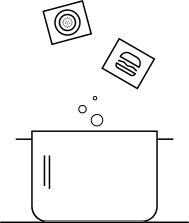
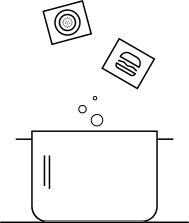
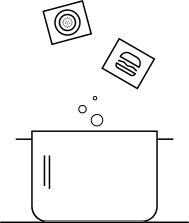
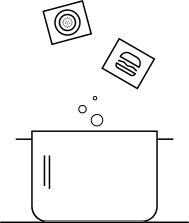
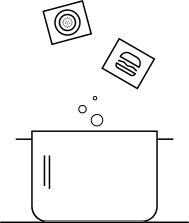
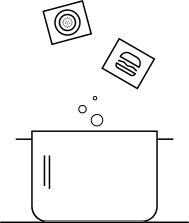
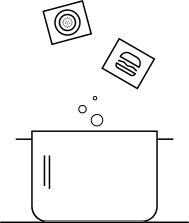
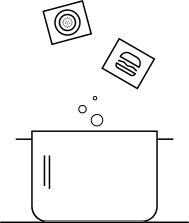
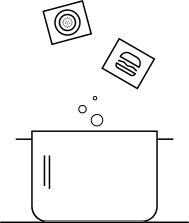
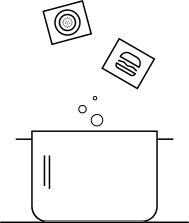
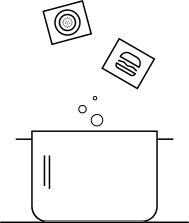
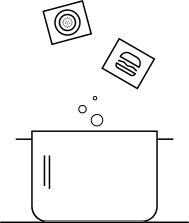
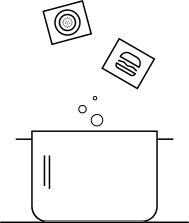
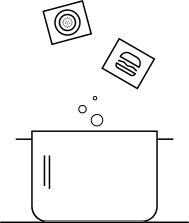
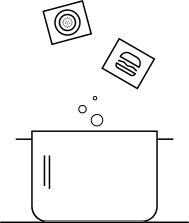
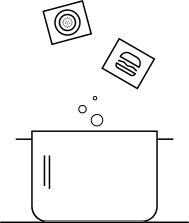
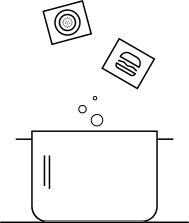
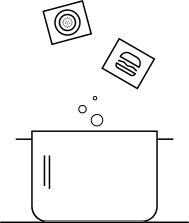
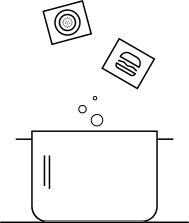
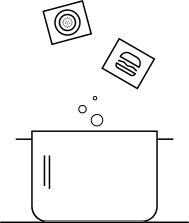
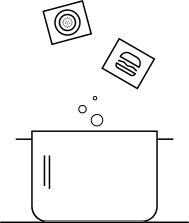
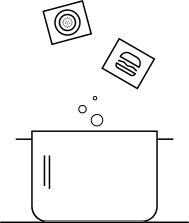
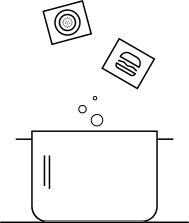
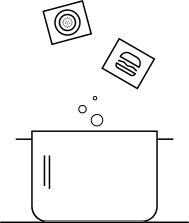
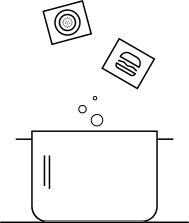
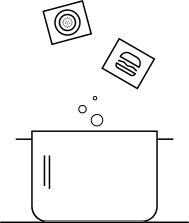
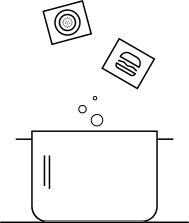
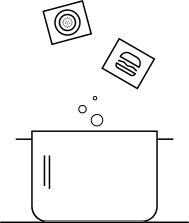
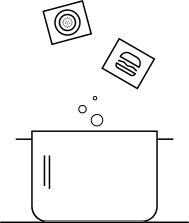
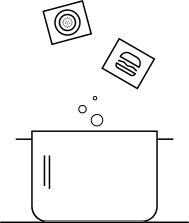
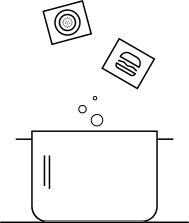
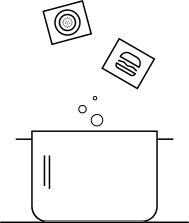
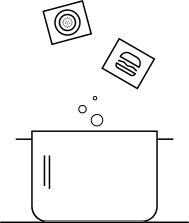
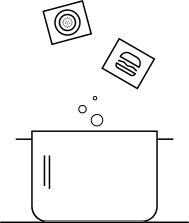
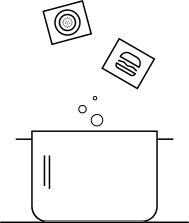
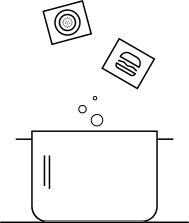
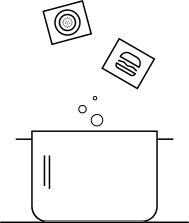
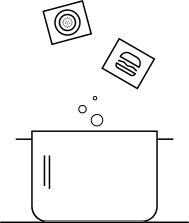
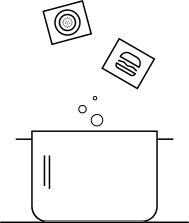
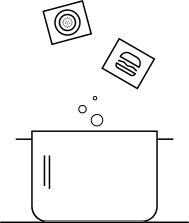
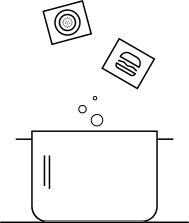
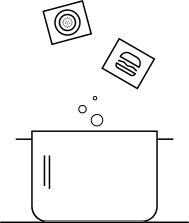
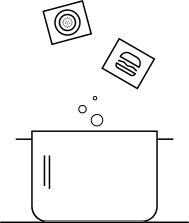
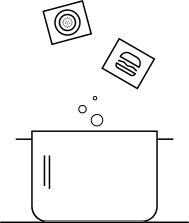
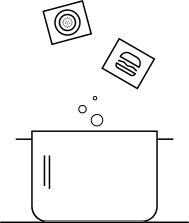
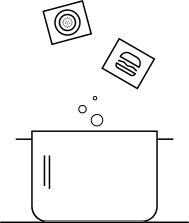
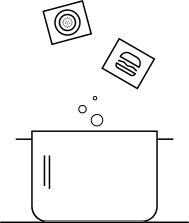
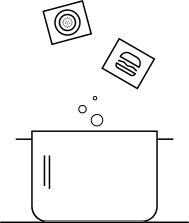
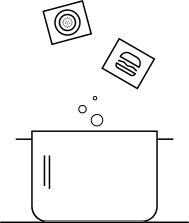
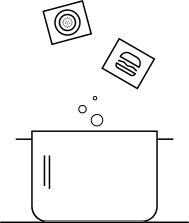
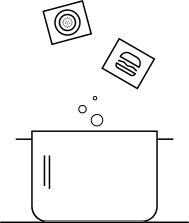
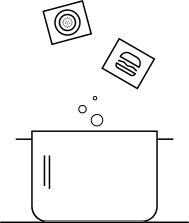
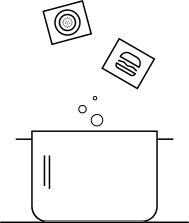
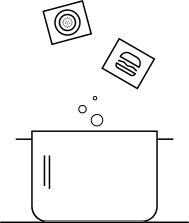
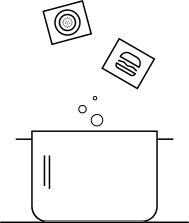
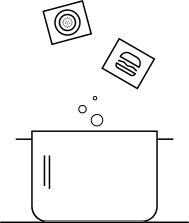
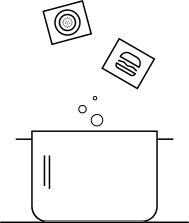
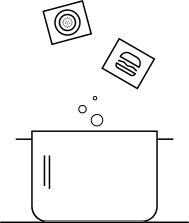
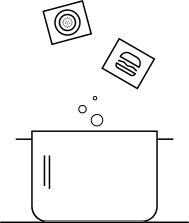
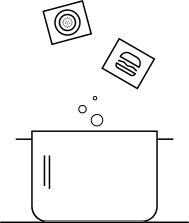
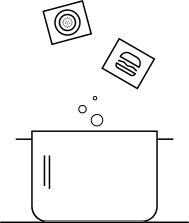
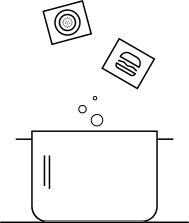
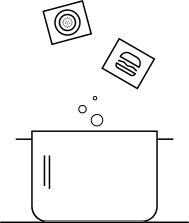
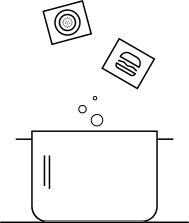
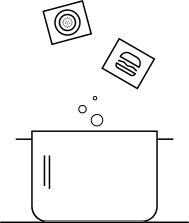
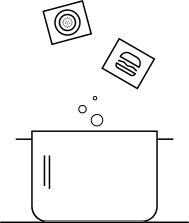
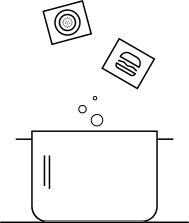
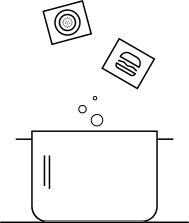
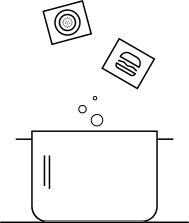
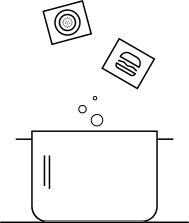
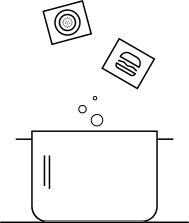
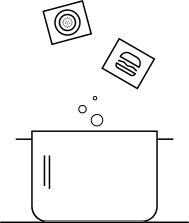
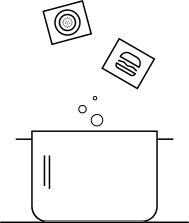
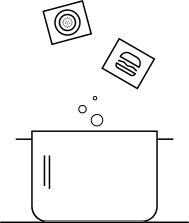
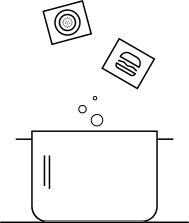
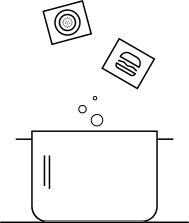
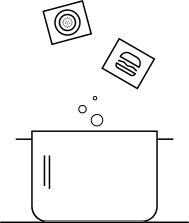
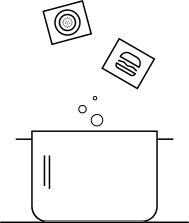
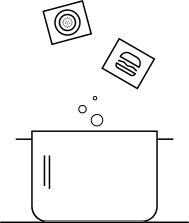
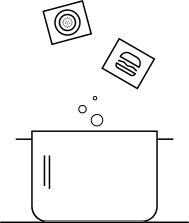
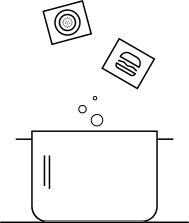
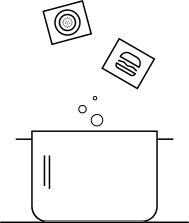
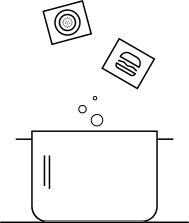
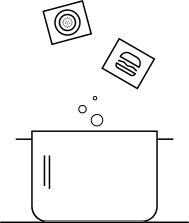
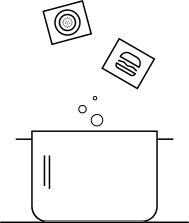
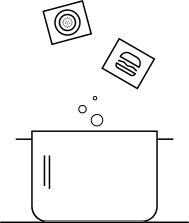

In [65]:
for j in range(1):
    linkers = CrawlerEda().get_links(1, 720)
    print(len(linkers))
    for i in linkers:
        DBHelper().insert("link", ["link", "photo"], [i.link, i.photo])

In [ ]:
links = DBHelper().print_info('link')
for l in links:
    #print(l)
    link = Link(l[1], l[2])
    print(l[1], l[2])
    ParserEda(CrawlerEda().get_card_info(link.link)).get_recipe(l[0])

https://eda.ru/recepty/vypechka-deserty/brauni-brownie-20955 https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/120131082911/130725174021/p_O.jpg
Брауни (brownie)
Sql error: UNIQUE constraint failed: recipe.id
Sql error: index unique_index_recipe_cat already exists
Sql error: UNIQUE constraint failed: category.name_cat
Sql error: UNIQUE constraint failed: recipe_categories.recipe_id, recipe_categories.cat_id
Sql error: UNIQUE constraint failed: category.name_cat
Sql error: UNIQUE constraint failed: recipe_categories.recipe_id, recipe_categories.cat_id
Sql error: UNIQUE constraint failed: category.name_cat
Sql error: UNIQUE constraint failed: recipe_categories.recipe_id, recipe_categories.cat_id
Sql error: index unique_index_recipe_ingr already exists
Sql error: UNIQUE constraint failed: ingredient.name_ingr
Sql error: UNIQUE constraint failed: ingredient.name_ingr
Sql error: UNIQUE constraint failed: ingredient.name_ingr
Sql error: UNIQUE constraint failed: ingredient.name_